## Machine Learning

### Time series analysis - predict levels of violence based on previous weeks.
We will attempt to predict levels of violence for upcoming weeks based on data from previous weeks. The production of this data could potentially be automated with a script and displayed on the Nepal Monitor platform alongside current data. Any predictions would likely need to have interpretable metrics and be displayed with a confidence score for purposes of accountability

### Data Preparation:

In [1]:
#list available files in directory
print('Raw Files:')
! ls Data
print('\nProcessed Files:')
! ls Data/output/

Raw Files:
1519759656_39328483.csv
2017 PMP Data Final No Duplicates.xlsx
Federal_VDC_Relation_web_clean.xlsx
Federal_VDC_Relation_web.xlsx
nepalmonitor-reports.csv
nepalmonitor-reports_old.csv
nepal_population_household_ward-2011.csv
NM_2016_17export.csv
npl_polbanda_adm5_wad_25k_50k_sdn_wgs84.csv
output

Processed Files:
District_Province_Population	 NM_2017-18_timeshift
NM_2016_17clean.csv		 NM_2017-18_timeshift_province
NM_2017-18_onehot_day		 pop_incidents_VDC.csv
NM_2017-18_onehot_week		 sources_vdc.csv
NM_2017-18_onehot_week_province


In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

#set up a custom qualitative color palette
xkcd_colors = ['purple','green','blue','pink','brown','red','light blue',\
              'tan','light green','magenta','yellow','sky blue','teal','orange','light purple']
catpal = sns.xkcd_palette(xkcd_colors)


#Import Primary Data Frames
cleanpath='Data/output/NM_2016_17clean.csv'#clean 2017 dataset
newpath = 'Data/nepalmonitor-reports.csv'#NM latest export - new site version
df = pd.read_csv(cleanpath)
new_df = pd.read_csv(newpath)

print(df.shape[0],'x',df.shape[1])
print(new_df.shape[0], 'x',new_df.shape[1])

6630 x 68
7203 x 55


Previous data cleaning efforts have focused on export data, from the previous Nepal Monitor platform. As of November 2018 a new version of NepalMonitor has been deployed, with a significantly streamlined export file. Machine Learning will focus on this new file format (new_df). 

In [3]:
#convert 'INCIDENT DATE' column to date time objects
    
new_df.loc[:,'Event Date'] = pd.to_datetime(new_df.loc[:,'Event Date'])
new_df.index = pd.to_datetime(new_df.loc[:,'Event Date'])
#new_df = new_df.loc['2017':'2018',:]# < taken out to have part of the 2017 data

print(df.shape)
print(new_df.shape)
new_df.head()

(6630, 68)
(7203, 55)


,#,Title,Nepali Title,Event Date,Publication Date,Location,Description,Nepali Description,Tags,Latitude,...,Youth raped,Total abducted,Female abducted,Youth abducted,Total damaged buildings,Severely damaged buildings,Total damaged vehicles,Severely damaged vehicles,Election-related cause - primary,Election-related cause - secondary
Event Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,21793,Complaint registered against rape,चकलेट दिन्छु भन्दै ५ बर्षीया बालिका बलात्कार।,2018-12-31,2018-12-31,"Province 2, Parsa, Pakahamainpur",A complaint against 19 years old Dev Kumar Pat...,पर्साको पकहामैनपुर गाउँपालिका १ मा धोरेमा ५ बर...,GBV\nChildren’s Rights,27.03046158726636,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-12-31,21803,Man held on charge of attempted rape,बलात्कार प्रयास घटनाका आरोपित गिरफ्तार ।,2018-12-31,2019-01-01,"Province 1, Morang, Biratnagar, Ward 10",Police have arrested 25 years old Gyanendra Sa...,१८ वर्षीया युवतीलाई बलात्कार प्रयास गरेको आरोप...,GBV,26.454562034856874,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-12-31,21804,Agitating civil servants take to streets,समायोजनविरुद्ध सडकमै उत्रिए निजामती कर्मचारी।,2018-12-31,2019-01-01,"Province 3, Kathmandu",Agitating civil servants today took to the str...,कर्मचारी समायोजन अध्यादेशको विरोधमा निजामती कर...,Governance,27.7058766168406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,21810,Complaint registered against rape,बलात्कार घटनाका आरोपितविरूद्ध उजुरी दर्ता।,2018-12-31,2019-01-02,"Province 2, Parsa",A complaint against 19 years old Dev Kumar Pat...,पाँच वर्षीया बालिकालाई बलात्कार गरेको आरोपमा प...,GBV\nChildren’s Rights,27.173588000000002,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-12-30,21779,Police arrests youth on rape charge,जवरजस्ती करणी गरेको अभियोगमा पक्राउ ।,2018-12-30,2018-12-30,"Province 5, Rukum East, Bhume, Ward 2",Police on Sunday arrested 22-year-old Laxman B...,पुथाउत्तरगंगा गाउँपालिका-१२ घर भई भूमे गाउँपाल...,GBV\nChildren’s Rights,28.545244075518408,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [4]:
#Drop out unneeded columns - leaving in provinces doesn't seem to break anything
new_drop = ['#','Title','Nepali Title', 'Ward','Publication Date','Event Date',
            'Nepali Description','Tags','Location','Latitude','Longitude']

test_df = new_df.dropna(axis=1, how='all')#.sort_index(axis=1)

test_df.drop(new_drop, axis=1, inplace=True)

In [5]:
#Fix minor inconsistencies in export file variables to facilitate dummy columns creation

#Some cells include the same cateogry name repeated on a new line. Strip out the second line.
def strip_newline(string):
    if type(string) == str:
        return string.split('\n')[0]#.lower().replace('nonviolent', 'non-violent').strip()
    else:
        return string

#Strip out anything contained in () and make everything lowercase
def strip_paren(string):
    if type(string) == str:
        return string.split('(')[0].lower()#.replace('nonviolent', 'non-violent').replace('noyouth', 'no-youth').strip()
    else:
        return string

#train_df = train_df.applymap(strip_paren)
full_df = test_df.applymap(strip_newline).applymap(strip_paren)

#train_df.append(test_df) < it looks like the variables are coded differently let's just use 1 dataset for now
full_df.loc[:,'Total killed'] = (full_df.loc[:,'Total killed'] == '1').astype(int)



In [6]:
#One-hot encode categorical columns
dummies = ['Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 'Cause - Secondary', 'Actor 1 - Affiliation', 'Actor 1 - Entity', 'Actor 1 - Youth/non-youth', 'Actor 2 - Target', 'Actor 2 - Affiliation','Actor 2 - Youth/non-youth']

incidents_date_test = pd.get_dummies(full_df, columns=dummies, dummy_na=False)

#strip out blank dummy categories 
for col in dummies:
    badstr = col+'_'
    if badstr in incidents_date_test.columns:
        incidents_date.drop(badstr, inplace=True, axis=1)
        print('dropped useless category:', badstr)
    
#aggrigate into weekly and daily dataframes
in_week = incidents_date_test.resample('W').sum()
in_day = incidents_date_test.resample('D').sum()

#Create weekly aggrigations by province
in_week_province = incidents_date_test.groupby('Province').resample('W').sum()

#Export data-frames CSV for opensource analysis
in_week.to_csv('Data/output/NM_2017-18_onehot_week')
in_day.to_csv('Data/output/NM_2017-18_onehot_day')
in_week_province.to_csv('Data/output/NM_2017-18_onehot_week_province')

print(in_week_province.shape)
#print(in_day_province.shape)
in_week_province.loc[('province 3',),:].head()


(737, 321)


,Total killed,Female killed,Youth killed,Total injured,Female injured,Total raped,Female raped,Youth raped,Total abducted,Female abducted,...,Actor 2 - Affiliation_security forces - apf,Actor 2 - Affiliation_security forces - army,Actor 2 - Affiliation_security forces - police,Actor 2 - Affiliation_security forces - security forces,Actor 2 - Affiliation_students,Actor 2 - Affiliation_unclear,Actor 2 - Youth/non-youth_na,Actor 2 - Youth/non-youth_noyouth,Actor 2 - Youth/non-youth_unknown,Actor 2 - Youth/non-youth_youth
Event Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-08,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,1.0
2017-01-15,2.0,0.0,1.0,4.0,3.0,2.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,5.0
2017-01-22,1.0,0.0,0.0,33.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,7.0,1.0,3.0,1.0
2017-01-29,3.0,1.0,2.0,18.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,3.0,1.0,3.0


Above, we have created a separate column for each variable tracked by the project, and given it a 1 if it was marked and a 0 if not (one hot encoding) and aggregated them by day and week, we have also created a separate data frame grouped by province for province-wise analysis, and saved all these data frames to CSV, so others interested in using the data can grab it directly in those formats

In [7]:
#function for converting pandas time series dataframe to training set for supervised learning
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
        Pandas DataFrame of series framed for supervised learning.
        https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
#Create a time shifted dataframe of all variables.
def make_timeshift(df, lookback):
    time_shift = series_to_supervised(df, lookback, dropnan=False).fillna(0)
    return time_shift

lookback=1
time_shift_week = make_timeshift(in_week, lookback)
time_shift_day = make_timeshift(in_day, lookback)
time_shift_province = make_timeshift(in_week_province, lookback)
print(time_shift_day.shape)
print(time_shift_week.shape)
test = pd.concat([time_shift_week['Total killed(t-001)'],time_shift_week['Total killed(t)']],axis=1)
print(test[:5])
#Save this for posterity
time_shift_week.to_csv('Data/output/NM_2017-18_timeshift')
time_shift_week.to_csv('Data/output/NM_2017-18_timeshift_province')

time_shift_province.head()



(730, 642)
(106, 642)
            Total killed(t-001)  Total killed(t)
Event Date                                      
2017-01-01                  0.0                2
2017-01-08                  2.0                9
2017-01-15                  9.0               11
2017-01-22                 11.0                4
2017-01-29                  4.0                8


Total killed(t-001)  Female killed(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                  0.0                   0.0   
           2017-01-08                  1.0                   0.0   
           2017-01-15                  2.0                   0.0   
           2017-01-22                  0.0                   0.0   
           2017-01-29                  2.0                   0.0   

                       Youth killed(t-001)  Total injured(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                  0.0                   0.0   
           2017-01-08                  0.0                   2.0   
           2017-01-15                  0.0                   4.0   
           2017-01-22                  0.0                   0.0   
           2017-01-29                  0.0                   3.0   

                       Female injured(t-001)  Total raped(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                    0.0                 0.0   
           2017-01-08                    0.0                 0.0   
           2017-01-15                    0.0                 1.0   
           2017-01-22                    0.0                 1.0   
           2017-01-29                    0.0                 1.0   

                       Female raped(t-001)  Youth raped(t-001)  \
Province   Event Date                                            
province 1 2017-01-01                  0.0                 0.0   
           2017-01-08                  0.0                 0.0   
           2017-01-15                  1.0                 1.0   
           2017-01-22                  1.0                 1.0   
           2017-01-29                  1.0                 0.0   

                       Total abducted(t-001)  Female abducted(t-001)  \
Province   Event Date                                                  
province 1 2017-01-01                    0.0                     0.0   
           2017-01-08                    0.0                     0.0   
           2017-01-15                    0.0                     0.0   
           2017-01-22                    0.0                     0.0   
           2017-01-29                    0.0                     0.0   

                                      ...                  \
Province   Event Date                 ...                   
province 1 2017-01-01                 ...                   
           2017-01-08                 ...                   
           2017-01-15                 ...                   
           2017-01-22                 ...                   
           2017-01-29                 ...                   

                       Actor 2 - Affiliation_security forces - apf(t)  \
Province   Event Date                                                   
province 1 2017-01-01                                             0.0   
           2017-01-08                                             0.0   
           2017-01-15                                             0.0   
           2017-01-22                                             0.0   
           2017-01-29                                             0.0   

                       Actor 2 - Affiliation_security forces - army(t)  \
Province   Event Date                                                    
province 1 2017-01-01                                              0.0   
           2017-01-08                                              0.0   
           2017-01-15                                              0.0   
           2017-01-22                                              0.0   
           2017-01-29                                              0.0   

                       Actor 2 - Affiliation_security forces - police(t)  \
Province   Event Date                                                      
province 1 20

The functions above take the aggregated data and "time shift" it so that can be used for supervised learning. It essentially puts a series of weeks on the same row as a given number of previous weeks represented by the "lookback" variable. The previous weeks will be used as input and the subsequent weeks will be used to train and score predictions based on that output. Again we have saved this data to CSV so others can grab it directly for analysis. 

Next we will create the X and y sets needed to to train the models, as well as a holdout set that the models will not "see" during training.

In [9]:
#Create X y - with holdhout split 
def create_X_y(df, holdpc=.25):
    '''function to create X y for training and holdout sets'''
    holdsize = int(holdpc * len(df.index))
    y = df.loc[:,'Total killed(t)':]#.iloc[:-holdsize,:]
    X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)']#.iloc[:-holdsize,:]
    
    holdout_y = df.loc[:,'Total killed(t)':].iloc[-holdsize:,:]
    holdout_X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)'].iloc[-holdsize:,:]

    return X, y, holdout_X, holdout_y

#create X_y for daily aggrigation
X_day, y_day, holdout_X_day, holdout_y_day = create_X_y(time_shift_day)

#create X_y for weekly aggrigation
X_week, y_week, holdout_X_week, holdout_y_week = create_X_y(time_shift_week)

#create X_y for weekly aggrigation by province
X_province, y_province, holdout_X_province, holdout_y_province = create_X_y(time_shift_province)

#print out shapes of datasets for sanity checking
for x in [X_day, y_day, holdout_X_day, holdout_y_day, X_week, y_week, holdout_X_week, holdout_y_week]:
    print(x.shape)

#output last 5 rows of y_province to show its stucture
y_province.tail()

(730, 321)
(730, 321)
(182, 321)
(182, 321)
(106, 321)
(106, 321)
(26, 321)
(26, 321)


Total killed(t)  Female killed(t)  Youth killed(t)  \
Province   Event Date                                                       
province 7 2018-12-02              0.0               0.0              0.0   
           2018-12-09              0.0               0.0              0.0   
           2018-12-16              0.0               0.0              2.0   
           2018-12-23              0.0               0.0              0.0   
           2018-12-30              1.0               0.0              0.0   

                       Total injured(t)  Female injured(t)  Total raped(t)  \
Province   Event Date                                                        
province 7 2018-12-02               0.0                0.0             1.0   
           2018-12-09               0.0                0.0             1.0   
           2018-12-16               0.0                0.0             0.0   
           2018-12-23               0.0                0.0             0.0   
           2018-12-30               1.0                1.0             0.0   

                       Female raped(t)  Youth raped(t)  Total abducted(t)  \
Province   Event Date                                                       
province 7 2018-12-02              1.0             1.0                0.0   
           2018-12-09              1.0             1.0                0.0   
           2018-12-16              0.0             0.0                0.0   
           2018-12-23              0.0             0.0                0.0   
           2018-12-30              0.0             0.0                0.0   

                       Female abducted(t)                 ...                  \
Province   Event Date                                     ...                   
province 7 2018-12-02                 0.0                 ...                   
           2018-12-09                 0.0                 ...                   
           2018-12-16                 0.0                 ...                   
           2018-12-23                 0.0                 ...                   
           2018-12-30                 0.0                 ...                   

                       Actor 2 - Affiliation_security forces - apf(t)  \
Province   Event Date                                                   
province 7 2018-12-02                                             0.0   
           2018-12-09                                             0.0   
           2018-12-16                                             0.0   
           2018-12-23                                             0.0   
           2018-12-30                                             0.0   

                       Actor 2 - Affiliation_security forces - army(t)  \
Province   Event Date                                                    
province 7 2018-12-02                                              0.0   
           2018-12-09                                              0.0   
           2018-12-16                                              0.0   
           2018-12-23                                              0.0   
           2018-12-30                                              0.0   

                       Actor 2 - Affiliation_security forces - police(t)  \
Province   Event Date                                                      
province 7 2018-12-02                                                0.0   
           2018-12-09                                                0.0   
           2018-12-16                                                0.0   
           2018-12-23                                                0.0   
           2018-12-30                                                0.0   

                       Actor 2 - Affiliation_security forces - security forces (t)  \
Province   Event Date                                                                
province 7 2018-12-02                                                0.0             
      

When the holdout percentage (holdout_pc) is set to .25 the holdout set represents approximately the final 6 months of 2018.  The need for the holdout set is complicated by the fact that this is time series analysis. Procedures needed to be tweaked to ensure that the model *never* "sees" future data when it is being trained, which may render the holdout set irrelevant. It has been removed for now

## Train predictive models:

The following is a core set of functions for training and testing various machine learning models. The output is a dry run used to ensure the functions are working. 

Dry Run:


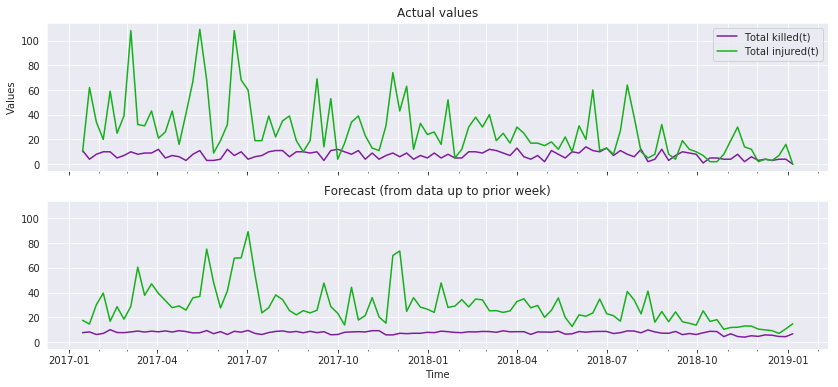

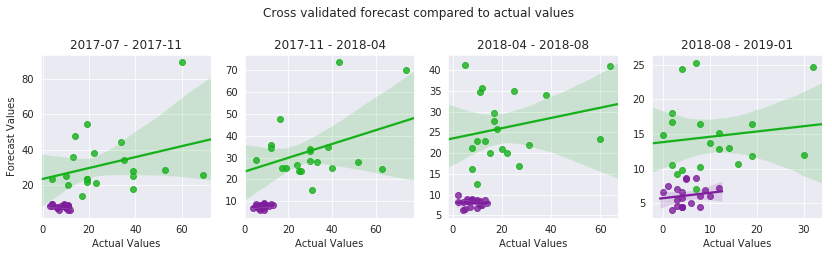

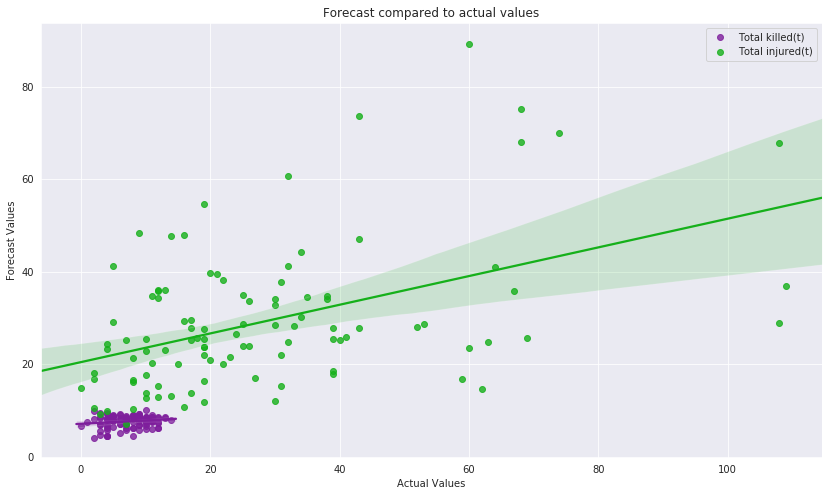

Baseline/Control - Forecast assuming each week has the same value as the previous week:


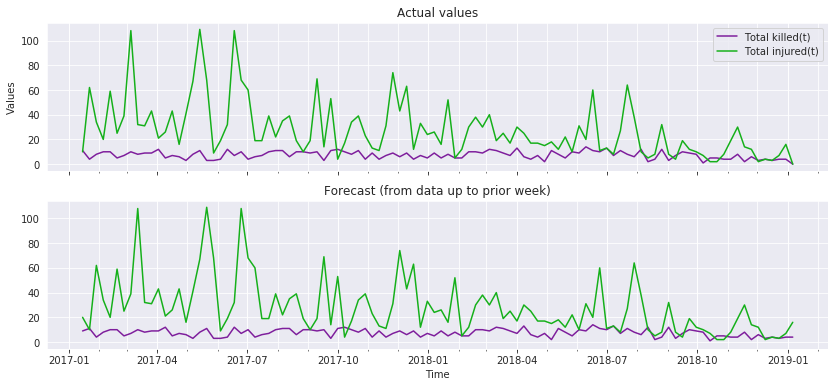

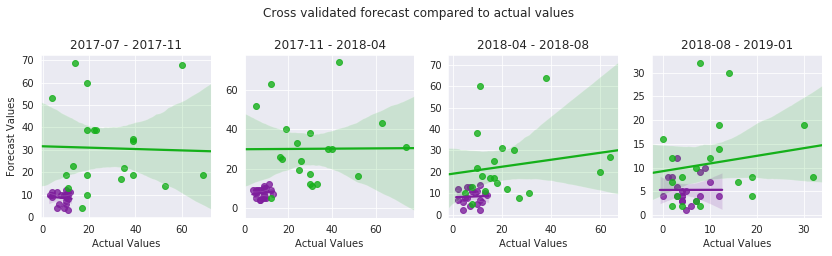

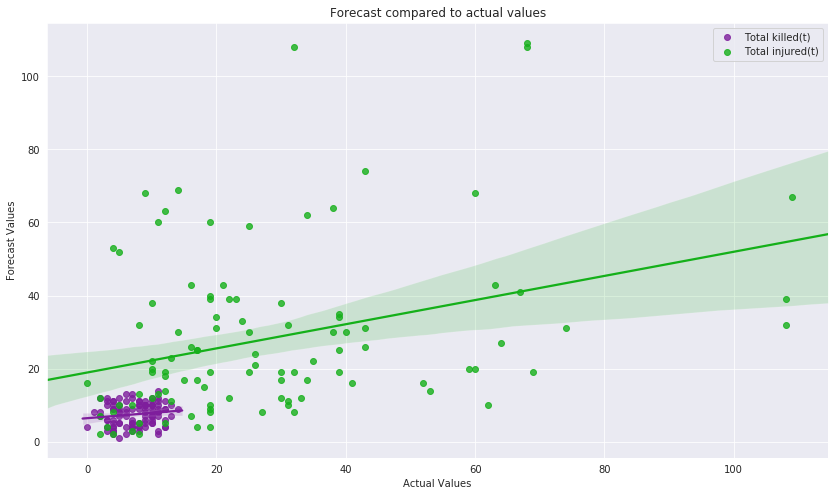

R_2:			 [-0.02749315  0.16010706]
Explained Variance:	 [-0.02295298  0.1624923 ]
Mean Squared Error:	 [  3.1823129   20.73158822]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.361803          -0.348933                3.240293   
Total injured(t) -0.381316          -0.319445               20.175728   

                        Q2                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)   0.033361           0.043201                2.428271   
Total injured(t) -0.111029          -0.090957               17.744450   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.081653          -0.081481                3.572604   
Total injured(t) -0.103596          -0.017243               16.551888   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)  -0.204004          -0.083693                3.289985  
Total injured(t) -0.401592          -0.183131               10.385037

In [10]:
#Train and test a given model

#import modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import check_cv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.dates as mdates

#create imputer for nan values - this module can be used to replace missing values
#with something that won't cause an error
imp = Imputer(missing_values='NaN', strategy = 'mean')


def plot_model(y_test, y_pred):
    '''Function to visualize what the model is doing to assist in evaluation'''
    #module for placing tick locations by month
    months = mdates.MonthLocator()  
    
    #put the predictions and desired values in a dataframe next to each other
    sync = pd.DataFrame(y_pred, index=y_test.index)
    
    #set style and colors
    sns.set_style('darkgrid')
    sns.set_palette(catpal)
    
    #1. plot predictions vs. ground truth in a time series
    
    #create subplots
    f, ax = plt.subplots(2,1, figsize=(14,6), sharex=True)
        
    #plot the input values - removed
    #ax[0].plot(X_test.sort_index())
    #ax[0].set_title('Test Input (previous weeks)')
    
    #plot the actual values
    ax[0].plot(y_test.sort_index(), )
    ax[0].set_title('Actual values')
    
    #plot the predictions
    ax[1].plot(sync.sort_index())
    ax[1].set_title("Forecast (from data up to prior week)")
    
    #label and show the plots 
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].set_xlabel('Time')
    ax[0].set_ylabel('Values')
    
    for x in range(2):
        ax[x].xaxis.set_minor_locator(months)
        ax[x].tick_params(which="both", bottom=True)
        ax[x].grid(which='minor')
    ax[0].legend(labels=y_test.columns)
    plt.rcParams.update({'font.size': 10})
    plt.show()
    
    
    #Plot cross validations - scatterplots of predictions v. actual values in 4 different time ranges 
    f, ax = plt.subplots(1,4, figsize=(14,3), sharey=False)
    qsplit = TimeSeriesSplit(n_splits=4)
    frm = '%Y-%m'
    x=0
    for _, test_index in qsplit.split(y_test):
        for var in range(y_test.shape[1]):
            sns.regplot(y_test.iloc[test_index,var], sync.iloc[test_index,var], ax=ax[x], color=catpal[var], label=y_test.columns[var])
        idx = y_test.iloc[test_index,:].index.strftime(frm)
        datestr = str(idx[0]) + ' - ' + str(idx[-1])
        ax[x].set_title(datestr)
        ax[x].set_xlabel('Actual Values')
        ax[x].set_ylabel('')
        x += 1
    
    #show the plot
    f.suptitle('Cross validated forecast compared to actual values', y=1.1)
    ax[0].set_ylabel('Forecast Values')
    plt.show()
    
    #plot a comparison of the actual values next to the predictions overall
    f, ax = plt.subplots(figsize=(14,8))

    for var in range(y_test.shape[1]):
        sns.regplot(y_test.iloc[:,var], sync.iloc[:,var], ax=ax, label=y_test.columns[var])
    ax.set_title('Forecast compared to actual values')
    ax.set_ylabel('Forecast Values')
    ax.set_xlabel('Actual Values')
    
    if y_test.shape[1] < 15:
        ax.legend(bbox_to_anchor=(1,1))
    
    #show the plot
    plt.show()

def test_model(X_train, X_test, y_train, model):
    '''Function to make predicitons using the model based on training input'''
    
    #impute any NaN values
    imp.fit_transform(X_train, y_train)
    
    #fit the model to the training set
    model.fit(X_train, y_train)

    #predict outcomes based on training set
    y_pred = model.predict(X_test)
    
    #bandaid to set negative predictions to 0
    np.clip(y_pred, a_min=0, a_max=None, out=y_pred)
    
    #return the predictions and trained model
    return y_pred, model 




def score_model(y_test, y_pred, verbose=False):
    '''fuction to score the model according to several metrics and return those metrics'''
    
    #impute any NaN values
    imp.fit_transform(y_test, y_pred)
    
    #score models
    r_2 = r2_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values')
    ev = explained_variance_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test.astype(float), y_pred.astype(float), multioutput='raw_values'))
       
    if verbose > 0:
        #Plot what these look like with fuction above if asked to
        plot_model(y_test, y_pred)
    
    #return train_score, test_score, r_2, ev, rmse, coefs, 
    return r_2, ev, rmse
    
def cv_score(y_test, y_pred):
    '''crossvalidate scores for continuiously trained time series'''
   
    #define varables for data frames - Note: these are not litterally yearly quarters. They don't line up that way
    qlist = ['Q1','Q2','Q3','Q4']
    vlist = ['r_2','explained_variance','root_mean_squared_error']
    cv = {}
    
    #instantiate time series splitter
    qsplit = TimeSeriesSplit(n_splits=4)
    
    #loop through splits and save scores to dataframe
    x=0
    for _, test_index in qsplit.split(y_test):
        r_2, ev, rmse = score_model(y_test.iloc[test_index], y_pred.iloc[test_index])
        scores = pd.DataFrame(index=y_test.columns, columns=vlist)
        scores.loc[:,'r_2'] = r_2
        scores.loc[:,'explained_variance'] = ev
        scores.loc[:,'root_mean_squared_error'] = rmse
        #save the dataframe in a dictionary
        cv[qlist[x]] = scores 
        x += 1
    
    #concat the dataframes together and return
    cv_df = pd.concat([cv['Q1'],cv['Q2'],cv['Q3'],cv['Q4']], axis=1, keys=cv.keys())
    return cv_df


def try_model(X, y, model, verbose=0, random_state=None):
    '''fuction to that takes a given model and a dataset, and evaluates the model
        -gives the option to plot relivant data
        -returns relivant scoring metrics'''

    #Split X and Y into training and testing sets using time series split. 
    #In this case X will consist of every week up until a given week in y,
    tscv = TimeSeriesSplit(n_splits=len(y)-1)
    
    #initialize data frames to fill with predictions and baseline scores
    y_pred = pd.DataFrame(index=y.index, columns=y.columns)
    y_control = y_pred.copy(deep=True)
    
    #A warm start adds training to a model rather than retraining it for new data.
    #to use one we have to increase the number of estimators with every run
    try: #first try getting the base no. of estimators from the model
        warm_start = model.get_params(deep=True)['n_estimators']
    except:#if that doesn't work just start with 0
        warm_start = 0
    
    #loop through every index of the time series split (every week)
    for train_index, test_index in tscv.split(X):
        
        #set training and testing values based on index.
        #Again X is every week before a given week in y.
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        #If model is using a warm start, set number of estimators based on
        #how many runs we've done, and change training set to a sliding window for efficency
        try:
            if model.get_params(deep=True)['warm_start'] == True:
                model.set_params(n_estimators=warm_start) 
                X_train, y_train = X_train[-16:], y_train[-16:]
        except: #if that doesn't work forget it
            pass
        
        y_control.iloc[test_index] = y.iloc[test_index-1].values
        
        #use functions above to train model and create predictions_
        try:
            y_pred.iloc[test_index], model = test_model(X_train, X_test, y_train, model)
        except:
            pass  #handle exception to return data up to any failure point
            
        warm_start+=10
        #debug logging
        
        if test_index.sum() < 0:
            print('\nRun:\t',test_index)
            print('X_train:\t', X_train.iloc[:,:2])
            print('y_train:\t', y_train.iloc[:,:2])
            print('X_test:\t', X_test.iloc[:,:2])
            print('y_pred:\t', y_pred.iloc[test_index])
            print('y_test:\t', y_test.iloc[:,:2])
            print('y_control:\t', y_control.iloc[test_index])
    
    y_test = y #for better plotting
    
    #return train/test split, predicitons and control - with front two datapoints chopped off 
    return X_train[2:], X_test[2:], y_train[2:], y_test[2:], y_pred[2:], y_control[2:].fillna(0)
    #lets not chop them off anymore
    #return X_train, X_test, y_train, y_test, y_pred, y_control.fillna(0) 
    
#define y - we'll just predict two variables for the dry run
y = y_week.loc[:,['Total killed(t)','Total injured(t)']] 

#instantiate a model to feed through the core functions
model = RandomForestRegressor(random_state=56)

#give the functions to try a given model a dry run to see if it works.
print('Dry Run:')

#try the model
X_train, X_test, y_train, y_test, y_pred, y_control = try_model(X_week, y, model, verbose = 2, random_state=56)
#score the model
dry_scores = score_model(y_test, y_pred, verbose=True)

#find and show the baseline scores - assuming one week will continue as the next
print('Baseline/Control - Forecast assuming each week has the same value as the previous week:')
control_scores = score_model(y_test, y_control, verbose=True)

#find and plot the crossvalidated scores

#print summary scores
dry_cv = cv_score(y_test, y_pred)
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')

dry_cv

The visualization above is the output of a "dry run" of one model, with a prediction of only two variables to ensure the core functions are working correctly, 

Ideally trends in the forecast for a given week or month, should line up with the trends in the actual values for that week. There appears to be a tendency of the forecast to lag behind trends in actual values, but in a few examples of the dry run the peaks and valleys in the trend and the forecast seem to match perfectly. This could be the result of random variation, but may also indicate the presence of leading indicators. 

In the scatter plot comparing actual values to forecast values, an ideal forecast would be a 45 degree line of dots representing a forecast values that matched actual values.  

Scores are indicated numerically by Root Mean Squared Error (an absolute interpretation of the size of the error, meaning large values are worse), explained variance (how much of the variance in the forecast is explained by the model) and R-squared(the proportion of the variance in the dependent variable that is predictable from the independent variable). The maximum score for the latter two is 1, with negative values indicating that using the mean of the actual values would result in a better forecast. 

In a final product on the Nepal Monitor Platform, R-squared or explained variance could be used to indicate accuracy percentages, while Root Mean Squared Error could be transformed into margin of error or confidence interval to show a range in which actual values are likely to fall.

A second set of plots is produced to show how a baseline model, which simply assumes a given week will have the same value of the previous week, would perform. To be acceptable, a model should have high positive R-squared and Explained variance scores, while also beating baseline scores. 

Dry Run (province 2):


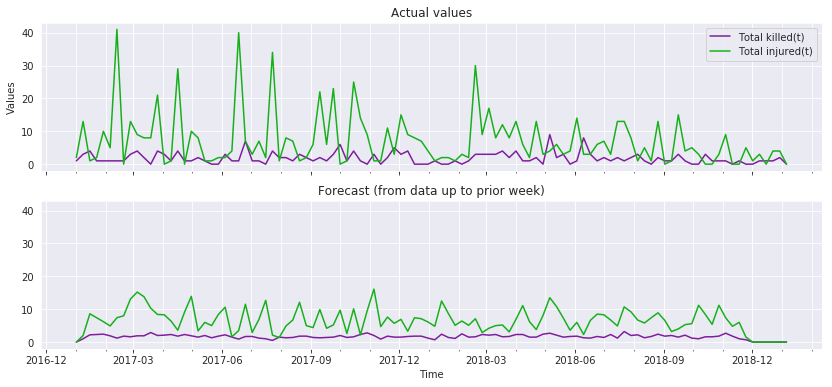

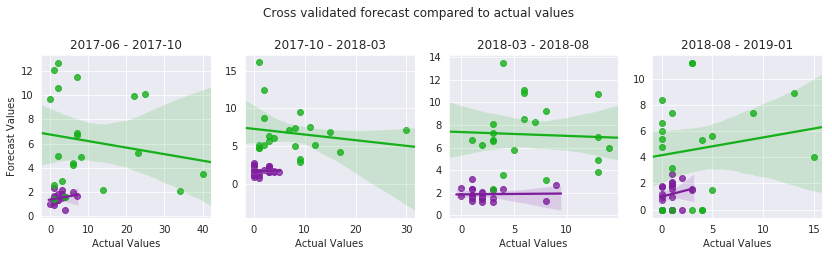

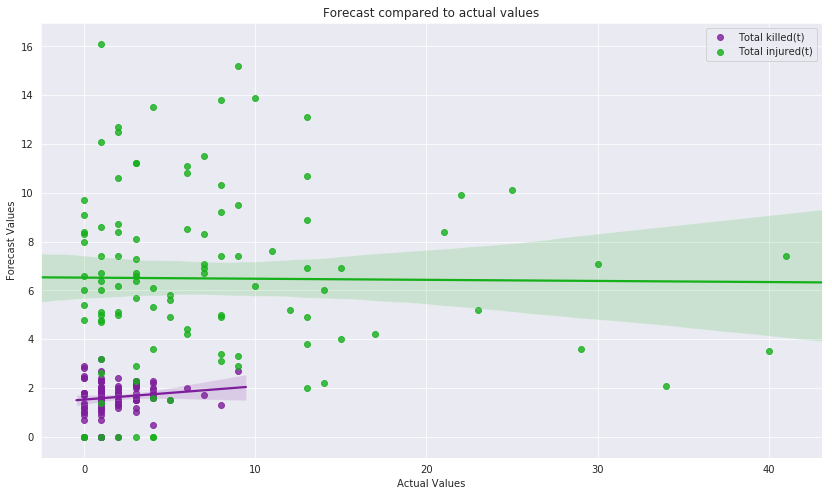

R_2:			 [-0.04843044 -0.2043495 ]
Explained Variance:	 [-0.03756372 -0.19682051]
Mean Squared Error:	 [ 1.74209806  9.06808627]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.125537           0.056075                1.849324   
Total injured(t) -0.339829          -0.213555               13.153598   

                        Q2                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.087843          -0.087631                1.707546   
Total injured(t) -0.345278          -0.336513                8.023596   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.082389          -0.039581                2.322663   
Total injured(t) -0.545628          -0.526107                5.127006   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)  -0.602725          -0.535281                1.137457  
Total injured(t) -0.595994          -0.507985                5.252074

In [11]:
def try_model_province(X, y, model, verbose=0, random_state=None):
    '''fuction to that takes a given model and a dataset, and evaluates the model on a per province basis
        -gives the option to plot relivant data
        -returns relivant scoring metrics'''
    
    
    #initialize empty dataframes for prediction and control values
    y_pred = pd.DataFrame(index=y.index, columns=y.columns)
    y_control = pd.DataFrame(index=y.index, columns=y.columns) 
    
    #set warmstart value for number of estimators   
    warm_start=10
    
    #loop through range of weeks
    for week in range(99):
        #loop through each province
        for pro in range(1,8):
            #extract data up to current week for given province
            province = 'province '+str(pro)
            X_prov, y_prov = X.loc[province], y.loc[province] 
            
            #split the data into training and testing indexes
            tscv = TimeSeriesSplit(n_splits=int(len(y_prov)-1))
            index = list(tscv.split(X.loc[province])) 
            train_index, test_index = index[week]
            X_train, X_test = X_prov.iloc[train_index], X_prov.iloc[test_index]
            y_train, y_test = y_prov.iloc[train_index], y_prov.iloc[test_index]
            
            #if model is using a warm start, set number of parameters based on
            #how many runs we've done, and change training set to a sliding window
            try:
                if model.get_params(deep=True)['warm_start'] == True:
                    model.set_params(n_estimators=warm_start) 
                    X_train, y_train = X_train[-16:], y_train[-16:]
            except:
                pass
                
            y_pred.loc[(province,),].iloc[test_index], model\
            = test_model(X_train, X_test, y_train, model)
            #model.fit(X_train.loc[(province,),:], y_train.loc[(province,),:])
            warm_start += 2
            
            #debug logging
            y_control.iloc[test_index] = y.iloc[test_index-1]
            if test_index.sum() < 0:
                print('\nRun:\t',test_index)
                print(province+':')
                print('X_train:\t', X_train.iloc[:,:2])
                print('y_train:\t', y_train.iloc[:,:2])
                print('X_test:\t', X_test.iloc[:,:2])
                print('y_pred:\t', y_pred.loc[province].iloc[test_index])
                print('y_test:\t', y_test.iloc[:,:2])
    
    y_test = y #we have been using only 1 y week at a time - return them all for better plotting
    
    #return train/test split, predicitons and control - with front two datapoints chopped off 
    return X_train[2:], X_test[2:], y_train[2:], y_test[2:], y_pred[2:], y_control[2:].fillna(0) 

#trying a dry run with provinces
#define y
y = y_province.loc[:,['Total killed(t)','Total injured(t)']] # > in_week.loc[:,'Total killed'].quantile(.5)      

model = RandomForestRegressor(random_state=56, warm_start=False)

print('Dry Run (province 2):')
#give the function to try a given model a dry run to see if it works.
X_train, X_test, y_train, y_test, y_pred, y_control = try_model_province(X_province, y, model, verbose = 2, random_state=56)
dry_scores = score_model(y_test.loc['province 2'], y_pred.loc['province 2'].fillna(0), verbose=True)
dry_cv_prov = cv_score(y_test.loc['province 2'], y_pred.loc['province 2'].fillna(0))
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')
#for x in ['Q1','Q2','Q3','Q4']:
#    print('\n',x)
#    print(dry_cv[x])
dry_cv_prov

The function above trains and tests a model just like before, but does it for every province separately. Using the province_wise dataframe. All provinces are tested and scored at once, but only "Province 2" is displayed above. "Province 3" is displayed below.

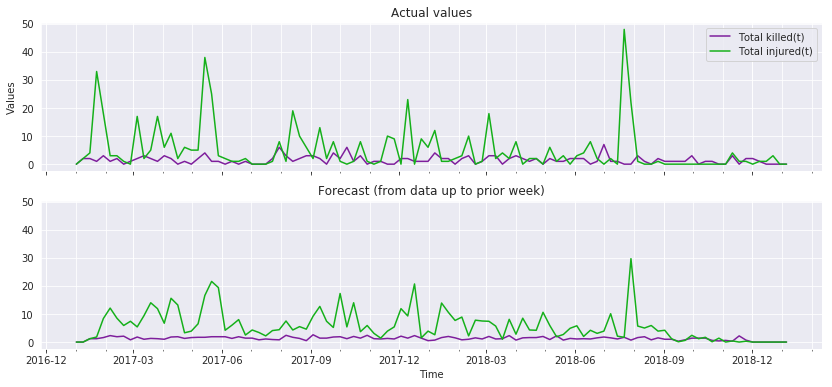

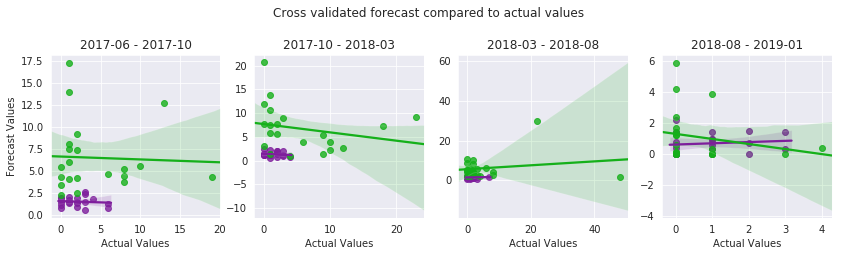

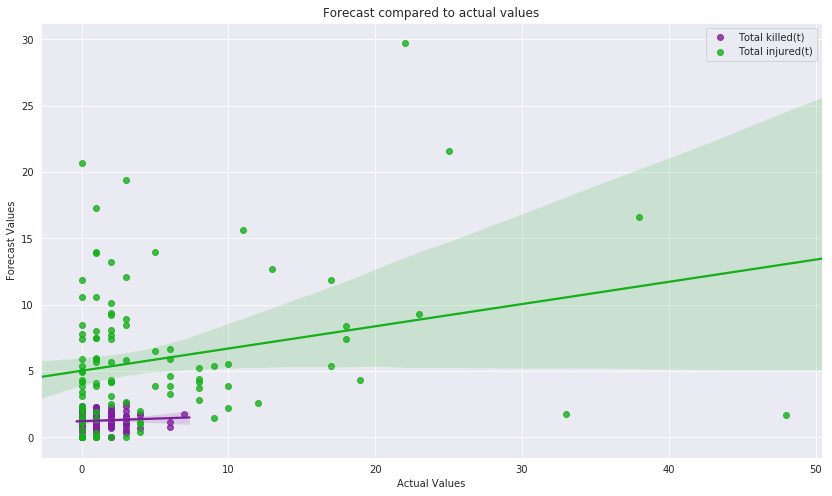

R_2:			 [-0.14402561 -0.10428133]
Explained Variance:	 [-0.12519676 -0.09333611]
Mean Squared Error:	 [ 1.47072053  8.58518909]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.195260          -0.139635                1.964567   
Total injured(t) -0.872588          -0.647939                6.860411   

                        Q2                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.320444          -0.320296                1.349250   
Total injured(t) -0.958428          -0.908873                8.771192   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.059371          -0.043144                1.539016   
Total injured(t) -0.107803          -0.104330               11.226457   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)  -0.292308          -0.241442                1.104105  
Total injured(t) -3.328765          -3.061358                2.184142

In [12]:
province = 'province 3'
dry_scores = score_model(y_test.loc[province], y_pred.loc[province].fillna(0), verbose=True)
dry_cv_prov = cv_score(y_test.loc[province], y_pred.loc[province].fillna(0))
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')
#for x in ['Q1','Q2','Q3','Q4']:
#    print('\n',x)
#    print(dry_cv[x])
dry_cv_prov

### Find variables with the best prediction scores

In [13]:
def get_coefs(X_train, y_train, model):
    '''get an array of coefficents or feature importances from the model - working for RandomForrest'''
    #create an empty array (no. output features * no. input features)     
    coefs = np.empty((y_train.shape[1], X_train.shape[1]))
    
    #first try looping through and getting the feature coefs for every estimator - for MultiOutputRegressor
    try:
        for n in range(len(model.estimators_)):
            coefs[n] = model.estimators_[n].coef_
    except:
        try: #if that throws an error just export the coef_ array directly from the model    
            coefs = model.coef_#np.empty(y_pred.shape)
        except:
            try: #if that throws an error we are probably using RandomForrest, and we just need the importances
                print('unable to fetch coefs, trying importance...')
                coefs = model.feature_importances_
                
            except: #if that throws an error we failed and we need to admit it
                print('Failed!')
    
    #creat a dataframe of coefficents and their feature labels
    print('Total feature coefs:', coefs.shape)
    #if coefs.shape[0] > 1:
    try: #first try making the dataframe out of the X_columns
        coefframe = pd.DataFrame(coefs, columns=['All Variables'], index=X_train.columns)
    except: #if that didn't work but it is more than one, it may be from a neural net.
        #find how many layers there are in the net.
        n_layers=coefs.shape[0]
        #make a list of the levels
        layerlst = []
        for x in range(n_layers):
            layerlst.append('layer_'+str(x))
        print(layerlst)
            #make a dataframe with the list of layers as the index
        coefframe = pd.DataFrame(coefs, index=layerlst, columns=X_train.columns)
        coefframe = coefframe.transpose() 
    
    #return the coefficent dataframe
    return coefframe

def interpret_coefs(coefframe, X_train, cats):
    '''plot histograms of the coefficients as well and bar charts of the top coefficients'''
    
    #plot histogram of coefficents for each variable in the categores passed 
    #loop through a range the length of the passed in categories
    n = 0
    for cat in cats:
        try: #first try plotting a histogram of coefs label according to passed in cat
            sns.distplot(coefframe[cat], color=catpal[n], label=cat)#.sort_values(1))
            print('plotting', cats[cat])
            plt.xlabel('feature coefficient', fontsize='x-large')
        except:
            pass
            #print("couldn't plot ", cats[cat])
        n += 1
    try:
        sns.distplot(coefframe)
        plt.xlabel('feature importance', fontsize='x-large')
        
    except:
        pass
    
   
    plt.legend(bbox_to_anchor=(1,1))
    plt.ylabel('density at given value', fontsize='x-large')
    plt.rcParams.update({'font.size': 13})
    plt.show()
    
  
        
    
    #plot top coefficents for each variable - currently doesn't do it, plotting top for one. 
    try:
        serieslist = []
        for cat in cats:
            serieslist.append(coefframe.loc[:,cat].nlargest(5))
            data = concat(serieslist, axis=1)
            print('Top feature coefs:\n', data.head())
    except:
        data=coefframe.nlargest(10, coefframe.columns)
        print('\nTop feature coefs:\n', data.head())
    n=0
    for cat in data.columns: 
        sns.swarmplot(y=data.index, x=cat, data=data, color=catpal[n], alpha=.5, size=10)
        n += 1
        
        #plt.legend()
    plt.ylabel('input category', fontsize='x-large')
    plt.xlabel('coef / importance', fontsize='x-large')
    plt.legend()
    plt.show()
    #return coefframe


Finding Variables...

Top Scoring Variables:


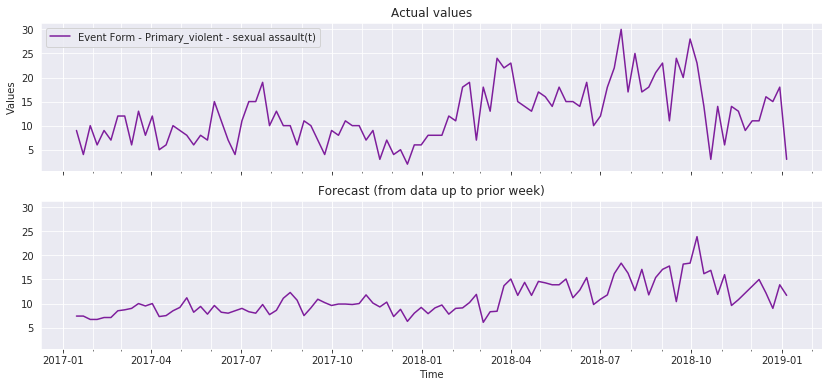

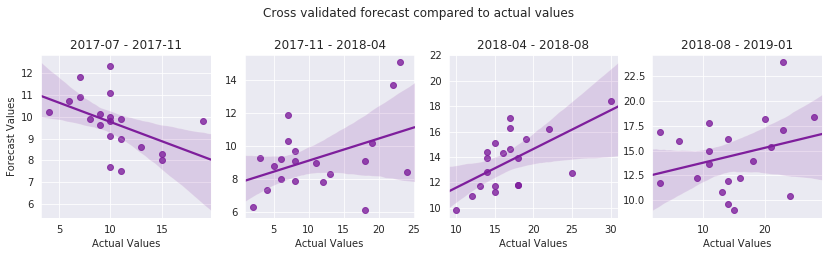

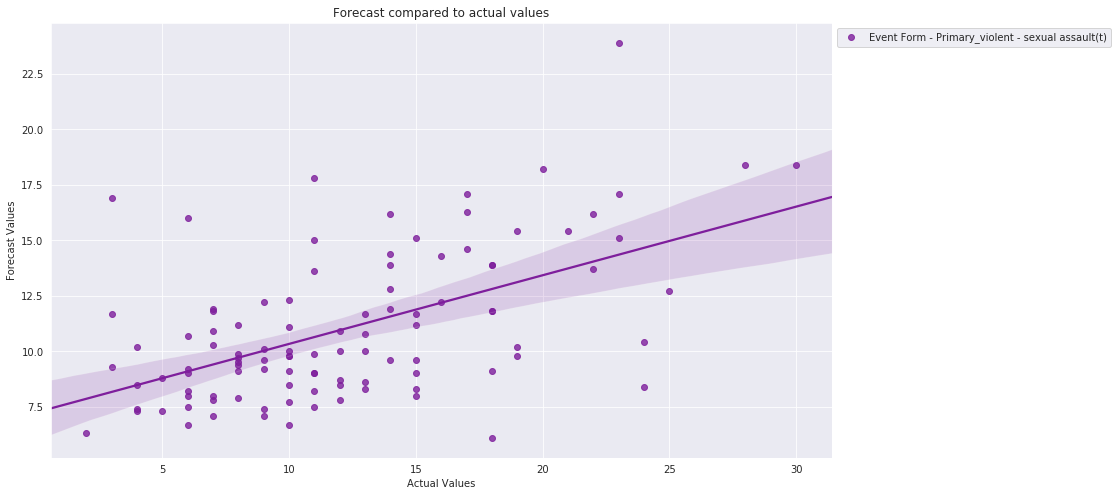

unable to fetch coefs, trying importance...
Total feature coefs: (321,)


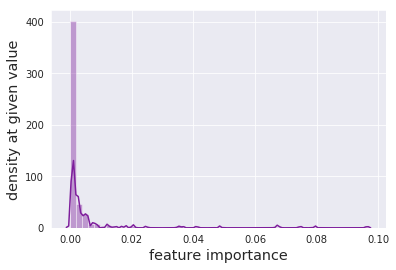


Top feature coefs:
                                                     All Variables
Collective / Interpersonal_collective(t-001)             0.096349
Actor 1 - Affiliation_unclear(t-001)                     0.079536
Cause - Primary_political - contestation over c...       0.074663
Event Form - Secondary_nonviolent - arrest (t-001)       0.067630
Actor 2 - Target_political organization/politic...       0.067081


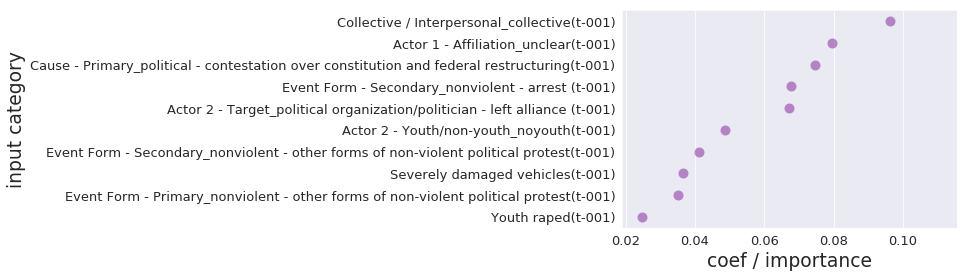

scores  \
                                                         r_2   
Event Form - Primary_violent - sexual assault(t)     0.26241   
Actor 1 - Youth/non-youth_unknown(t)                0.251101   
Collective / Interpersonal_collective(t)            0.214787   
Cause - Primary_political - election-related in...  0.196403   
Actor 2 - Youth/non-youth_unknown(t)                0.189529   
Total raped(t)                                      0.182729   
Weapons_improvised explosive device (t)             0.170281   
Female raped(t)                                     0.159909   
Onesided / Twosided_onesided(t)                     0.138751   
Collective / Interpersonal_interpersonal(t)         0.133687   

                                                                       \
                                                   explained_variance   
Event Form - Primary_violent - sexual assault(t)             0.302341   
Actor 1 - Youth/non-youth_unknown(t)                         0.272574   
Collective / Interpersonal_collective(t)                     0.234222   
Cause - Primary_political - election-related in...           0.197157   
Actor 2 - Youth/non-youth_unknown(t)                         0.195436   
Total raped(t)                                               0.243311   
Weapons_improvised explosive device (t)                      0.170282   
Female raped(t)                                              0.213411   
Onesided / Twosided_onesided(t)                              0.143717   
Collective / Interpersonal_interpersonal(t)                  0.135771   

                                                                            \
                                                   root_mean_squared_error   
Event Form - Primary_violent - sexual assault(t)                   5.10372   
Actor 1 - Youth/non-youth_unknown(t)                               20.5448   
Collective / Interpersonal_collective(t)                           24.5022   
Cause - Primary_political - election-related in...                 24.7044   
Actor 2 - Youth/non-youth_unknown(t)                                 8.909   
Total raped(t)                                                     5.28336   
Weapons_improvised explosive device (t)                            11.8056   
Female raped(t)                                                    5.18185   
Onesided / Twosided_onesided(t)                                    16.4746   
Collective / Interpersonal_interpersonal(t)                        8.88097   

                                                   control_scores  \
                                                              r_2   
Event Form - Primary_violent - sexual assault(t)          0.15976   
Actor 1 - Youth/non-youth_unknown(t)                     0.012414   
Collective / Interpersonal_collective(t)                0.0280466   
Cause - Primary_political - election-related in...       0.055514   
Actor 2 - Youth/non-youth_unknown(t)                    -0.359472   
Total raped(t)                                         -0.0101023   
Weapons_improvised explosive device (t)                 0.0283659   
Female raped(t)                                        -0.0162102   
Onesided / Twosided_onesided(t)                         -0.142361   
Collective / Interpersonal_interpersonal(t)             0.0203266   

                                                                       \
                                                   explained_variance   
Event Form - Primary_violent - sexual assault(t)             0.159854   
Actor 1 - Youth/non-youth_unknown(t)                        0.0126509   
Collective / Interpersonal_collective(t)                    0.0281704   
Cause - Primary_political - election-related in...           0.055514   
Actor 2 - Youth/non-youth_unknown(t)                        -0.359412   
Total raped(t)                                              -0.010059   
Weapons_improvised explosive device (t)                   

In [14]:
#find which variables have the best scores

def find_var (X, df, model, n_true, verbose=False, random_state=None, s_plot=0, n_plot=1, province=''):
   
    #filter out varables where the perentage "true" is less than n_true, to avoid completely unbalanced data
    pc_true = [sum(df[x] >= 1)/len(df[x])*100 > n_true for x in df.columns]
    y = df.loc[:,pc_true] 
    
    if province != '':  
        X_train, X_test, y_train, y_test, y_pred, y_control = try_model_province(X, y, model, verbose=False)
        y_test = y_test.loc[province].dropna()
        y_pred = y_pred.loc[province].fillna(0)
        y_control = y_control.loc[province].fillna(0)
    
    else:
        X_train, X_test, y_train, y_test, y_pred, y_control = try_model(X, y, model, verbose=False)
    
    
    #score the model
    r_2, ev, rmse = score_model(y_test, y_pred, verbose=False)
    
    #Score the model based on control (simply continuing the values from the previous week). 
    r_2_c, ev_c, rmse_c, = score_model(y_test, y_control, verbose=False)
    
    
    #save all these scores in data frames
    collist = ['r_2','explained_variance','root_mean_squared_error']    
    scores = pd.DataFrame(index=df.columns, columns=(collist))
    scores_c = pd.DataFrame(index=df.columns, columns=(collist))
    
    scores.loc[pc_true,'r_2'] = r_2
    scores.loc[pc_true,'explained_variance'] = ev
    scores.loc[pc_true,'root_mean_squared_error'] = rmse

    scores_c.loc[pc_true,'r_2'] = r_2_c
    scores_c.loc[pc_true,'explained_variance'] = ev_c
    scores_c.loc[pc_true,'root_mean_squared_error'] = rmse_c
    
    #crossvalidate quarterly periods
    cv_scores = cv_score(y_test, y_pred)
    
    #calculate cv means
    cv_mean = pd.DataFrame(index=cv_scores.index)
    #cv_mean.set_columns(['cv_mean',collist],inplace=True)
    for x in range(3):
        col = collist[x]
        cv_mean.loc[:,col] = [cv_scores.iloc[y,x::3].agg('mean') for y in range(len(cv_scores))]
    
    if verbose > 1:
        #print scores
        #print('total train score:', train_score )
        #print('total test score:', test_score)
        print('\ntop score r_2:',scores['r_2'].max())
        print('top score explained variance:',ev.max())
        print('best score rmse:',rmse.min()) 
        
        print('\ncontrol test - forcast using exact values of previous week:')
        print('top score r_2:',r_2_c.max())
        print('top score explained variance:',ev_c.max())
        print('best score rmse:',rmse_c.min())
    
    #add crossvalidated scores to dataframe
    
    cv_mean.columns = pd.MultiIndex.from_product([['cv_mean'],collist])
    scores.columns = pd.MultiIndex.from_product([['scores'],collist])
    scores_c.columns = pd.MultiIndex.from_product([['control_scores'],collist])
    
    scores = pd.concat([scores, scores_c, cv_mean, cv_scores], axis=1)    
    
    #filter out explained variance scores below 
    top = scores.loc[scores[('scores','explained_variance')] > -1].sort_values(('scores','r_2'), ascending=False)
    
    #filter out scores that don't beat the control - (errors are higher than control)
    worse = top.loc[top[('scores','root_mean_squared_error')] > top[('control_scores','root_mean_squared_error')]]
    top.drop(worse.index, inplace=True)
    
    #find differences between model and control in R_2
    diff = (top[('scores','r_2')] - top[('control_scores','r_2')])#.sort_values(ascending=False)
    
    #filter out low differences with control
    top = top.loc[diff > .1]
    
    
    if verbose > 0:
        #plot what the best scores look like. 
        print("\nTop Scoring Variables:")
        yfilt = [ x in top[s_plot:n_plot].index.tolist() for x in y_test.columns]
        plot_model(y_test.loc[:,yfilt], y_pred.loc[:,yfilt])
    
    if verbose > 1:
    #plot what the control scores look like
        #print(y_control)
        plot_model(y_test.loc[:,yfilt], y_control.loc[:,yfilt])
    
    #top_scores = score_model(X_train, X, y_train.loc[:,top.index[:3]], y.loc[:,top.index[:3]], y_pred.loc[:,top.index[:3]], model, verbose=verbose)
    #top_scores = find_var(X_week, y_week.loc[:,better.index[:3]], model, n_true=20, verbose=2, random_state=38)
    return scores, top

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)
#for step in range(5,y_week.shape[1])[::5]:
    #model = MultiOutputRegressor(ARDRegression(), n_jobs=-1)
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    #model = LinearRegression()
    model = RandomForestRegressor(random_state=56, warm_start=False)
    
    print("Finding Variables...")
    scores, top = find_var(X_week, y_week, model, n_true=20, verbose=1, n_plot=1)
    #get feature coeficents and feature importance
    coefs = get_coefs(X_train, y_train, model)
    coefframe = interpret_coefs(coefs,X_train,top.index)
    
    #print top 10 scores that beat control
top[:10]
    

Here we are asking RandomForrestRegressor to predict all variables one week ahead as best as it can using all variables as input features. We are filtering out variables that don't beat control scores and plotting the top scoring variable. Additionally we are plotting a histogram of the feature importances, and showing the top 10 most important features. It is clear that relatively few features are important to the model. This information can be used for analysis of which variables may be the best indicators of violence, as well as for pruning features out to increase computational efficiency.

### Optimize Models

In [15]:
#Optimize / Tune Model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def random_search(params, model, n_iter):
    #define splitter... time series split?
    qsplit = TimeSeriesSplit(n_splits=4)

    #instantiate randomized search - use normal scoring function
    Search = RandomizedSearchCV(model, param_distributions=params, cv=qsplit, n_jobs=-1, n_iter=n_iter)

    #fit X_week, Y_week
    Search.fit(X_week, y_week)

    #find the best scoring model
    best_params = Search.best_params_
    best_score = Search.best_score_
    #show the results
    results = Search.cv_results_
    #print('results:\n',results)
    #define param grid - get params from model - test first
    return best_params, best_score, results

#instantiate model
model = RandomForestRegressor(random_state=56)    

#set paramaters
params = {'n_estimators':range(150,300,1),
          'warm_start':[False],
          'max_depth':range(1,300,1),
          'min_samples_split':np.linspace(0.00000001,.1,100),
          'min_samples_leaf':range(5,6,1),
          'min_weight_fraction_leaf':np.linspace(.0000001,.1,100),
          'max_features':range(150,200,1),
          'max_leaf_nodes':range(180,300,1),
          'min_impurity_decrease':np.linspace(0.000001,.1,100)}

#random search parameters, returning the best scores and results.
best_params, best_score, results = random_search(params, model, 20)
print('\nbest parameters',best_params)
print('best score',best_score)


best parameters {'warm_start': False, 'n_estimators': 251, 'min_weight_fraction_leaf': 0.034343500000000006, 'min_samples_split': 0.078787880909090918, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.084848636363636362, 'max_leaf_nodes': 192, 'max_features': 174, 'max_depth': 111}
best score -0.411066581794


plotting 9 params...


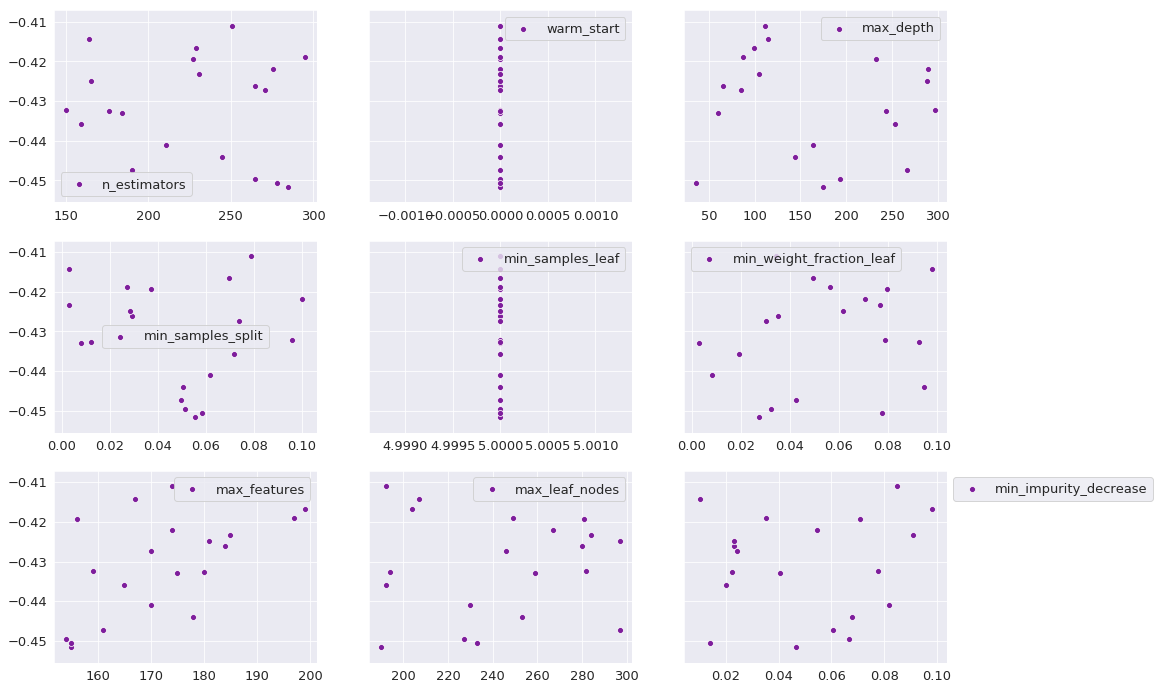

In [16]:
#Plot results of parameter search
def plot_params(params, results):
    '''plots the results of a given parameter search for optimization'''
    #set how many plots there will be acourding to the number of parameters
    plotlen = len(params.keys())
    
    #set the hieght of the plot according to 1/3 the number of plots
    plotht = int((plotlen+1)/3)
    
    #print something to show we are working
    print('plotting', plotlen, 'params...')
    
    #create the subplot gird with 3 columns and a hight according to the number of plots
    f, ax = plt.subplots(plotht,3, figsize = (16,plotht*4), sharey=True)

    #loop through random_search results and plot paramater values against scores 
    count = 0
    for key in params.keys():
        ax1 = int(count/3)
        ax2 = count%3
        
        #first try plotting normally.
        try:
            sns.scatterplot(results['param_'+key],results['mean_test_score'], label=key, ax=ax[ax1][ax2])
        
        #If that doesn't work it could be because it's a list of hidden layers on a neural net. Handle that.
        except:
            lst = []
            for item in results['param_'+key]:
                lst.append(item[0])
                #print(lst)
            sns.scatterplot(lst ,results['mean_test_score'], label=key)
        
        plt.legend(bbox_to_anchor=(1,1))
        count += 1
             
        #print(count, ax1, ax2)
    plt.show()
    
plot_params(params, results)

The results plot above is used to refine the parameter space of the random hyper parameter search in order to tune the model.  The parameter search trains and scores the model 100 times using randomly chosen parameters within the given parameter space. These parameters are then scatterplotted against the resulting score.  Downward trends on either end of a given parameter range can then be eliminated and fed back into the randomized search, until the scatterplots appear random. The resulting tuned parameters are then used for the model going forward.  

If the plots above appear random the model is optimized.

Finding Variables...

top score r_2: 0.3265190001296687
top score explained variance: 0.33196861987
best score rmse: 0.422020915709

control test - forcast using exact values of previous week:
top score r_2: 0.402915094814
top score explained variance: 0.402915094814
best score rmse: 0.554700196225

Top Scoring Variables:


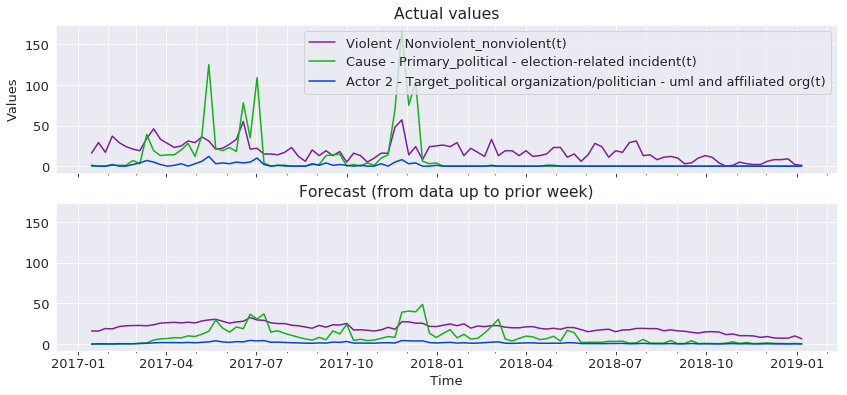

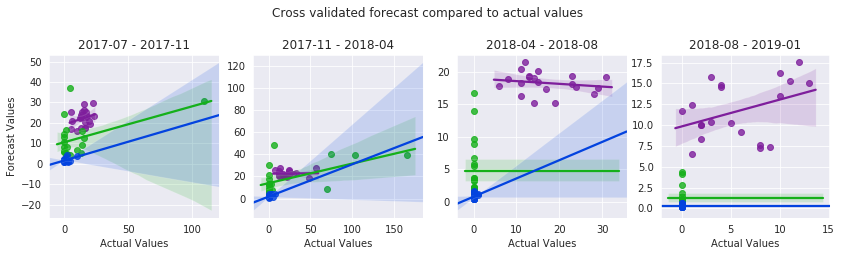

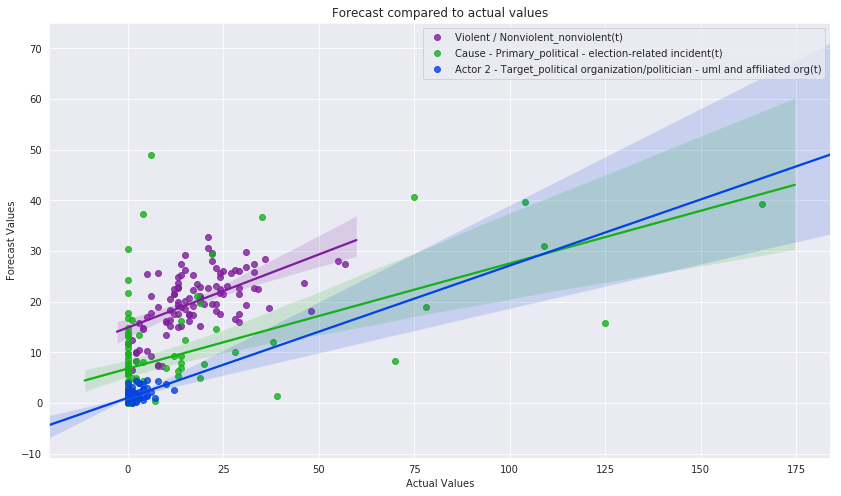

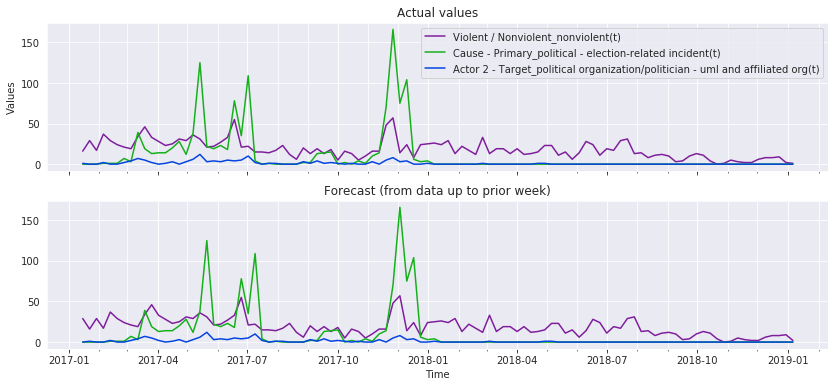

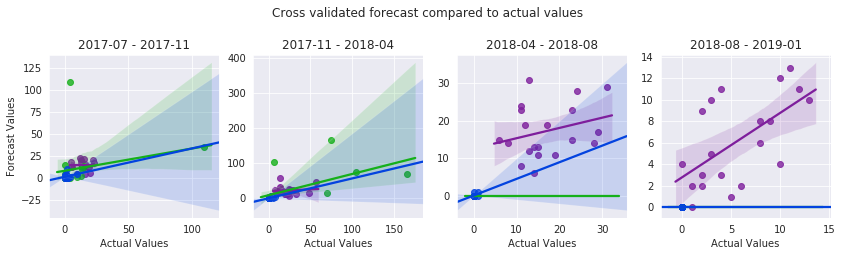

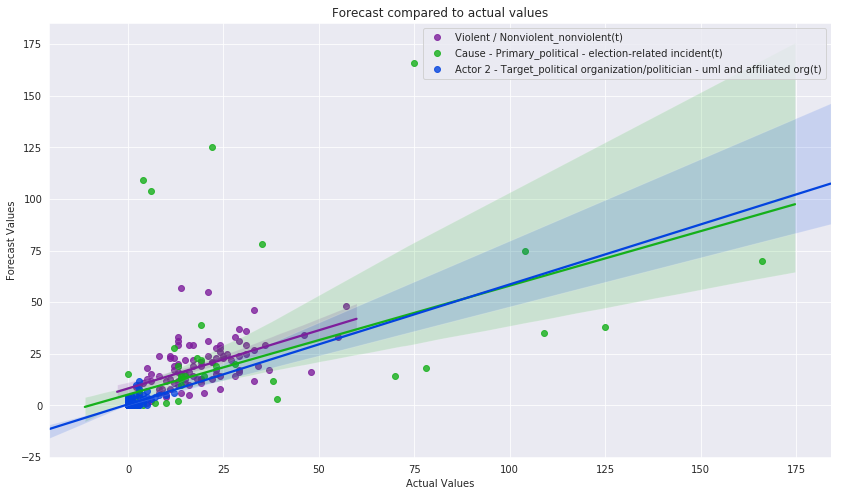

unable to fetch coefs, trying importance...
Total feature coefs: (321,)


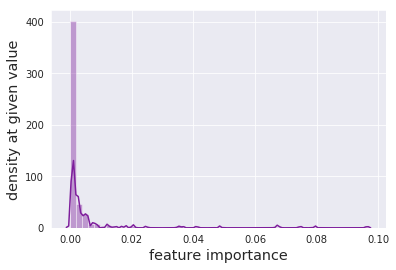


Top feature coefs:
                                                     All Variables
Collective / Interpersonal_collective(t-001)             0.096349
Actor 1 - Affiliation_unclear(t-001)                     0.079536
Cause - Primary_political - contestation over c...       0.074663
Event Form - Secondary_nonviolent - arrest (t-001)       0.067630
Actor 2 - Target_political organization/politic...       0.067081


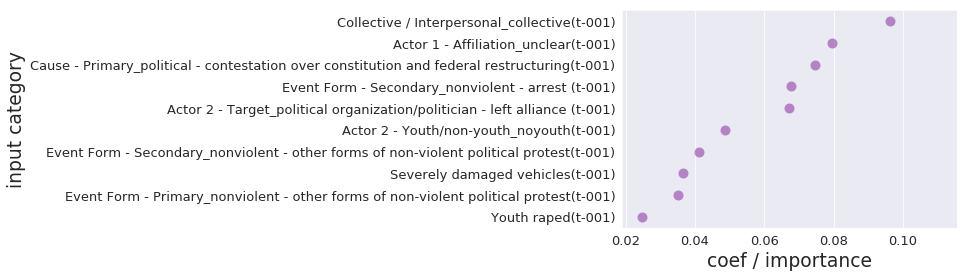

scores  \
                                                         r_2   
Actor 1 - Youth/non-youth_unknown(t)                0.326519   
Collective / Interpersonal_collective(t)            0.323161   
Actor 2 - Youth/non-youth_na(t)                     0.301838   
Violent / Nonviolent_nonviolent(t)                  0.284274   
Actor 2 - Target_political organization/politic...  0.276771   
Cause - Primary_political - election-related in...  0.266083   
Total raped(t)                                      0.196426   
Onesided / Twosided_onesided(t)                      0.19562   
Total injured(t)                                    0.191164   
Actor 2 - Youth/non-youth_unknown(t)                0.187376   

                                                                       \
                                                   explained_variance   
Actor 1 - Youth/non-youth_unknown(t)                         0.331969   
Collective / Interpersonal_collective(t)                     0.324302   
Actor 2 - Youth/non-youth_na(t)                              0.303992   
Violent / Nonviolent_nonviolent(t)                           0.316213   
Actor 2 - Target_political organization/politic...           0.280475   
Cause - Primary_political - election-related in...           0.271143   
Total raped(t)                                               0.287871   
Onesided / Twosided_onesided(t)                                0.1997   
Total injured(t)                                              0.19808   
Actor 2 - Youth/non-youth_unknown(t)                          0.18745   

                                                                            \
                                                   root_mean_squared_error   
Actor 1 - Youth/non-youth_unknown(t)                               19.4829   
Collective / Interpersonal_collective(t)                           22.7485   
Actor 2 - Youth/non-youth_na(t)                                    15.0137   
Violent / Nonviolent_nonviolent(t)                                 9.42853   
Actor 2 - Target_political organization/politic...                 1.89309   
Cause - Primary_political - election-related in...                  23.609   
Total raped(t)                                                      5.2389   
Onesided / Twosided_onesided(t)                                    15.9214   
Total injured(t)                                                   20.3447   
Actor 2 - Youth/non-youth_unknown(t)                               8.92083   

                                                   control_scores  \
                                                              r_2   
Actor 1 - Youth/non-youth_unknown(t)                     0.012414   
Collective / Interpersonal_collective(t)                0.0280466   
Actor 2 - Youth/non-youth_na(t)                         0.0817405   
Violent / Nonviolent_nonviolent(t)                       0.141002   
Actor 2 - Target_political organization/politic...       0.161728   
Cause - Primary_political - election-related in...       0.055514   
Total raped(t)                                         -0.0101023   
Onesided / Twosided_onesided(t)                         -0.142361   
Total injured(t)                                        -0.325367   
Actor 2 - Youth/non-youth_unknown(t)                    -0.359472   

                                                                       \
                                                   explained_variance   
Actor 1 - Youth/non-youth_unknown(t)                        0.0126509   
Collective / Interpersonal_collective(t)                    0.0281704   
Actor 2 - Youth/non-youth_na(t)                             0.0819492   
Violent / Nonviolent_nonviolent(t)                           0.141586   
Actor 2 - Target_political organization/politic...           0.161728   
Cause - Primary_political - election-related in...           0.055514   
Total raped(t)                                            

In [17]:
#call find var again, using params from above.  
model = RandomForestRegressor(random_state=56, **best_params)
    
print("Finding Variables...")
scores, top = find_var(X_week, y_week, model, n_true=20, verbose=2, s_plot=3, n_plot=6)

#extract and plot feature coefs
coefframe = get_coefs(X_train, y_train, model)
interpret_coefs(coefs,X_train,top.index)

    #print top 10 scores that beat control
top[:10]

The results of the tuned model are clearly better than the un-tuned model. While the top score has not improved significantly, far more variables approach the highest scoring variable.

Next we will tune MLPRegressor

In [18]:
#get parameter set from MLPRegressor
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(random_state=56)
model.get_params(deep=True)

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 56,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [19]:
#Tune MLPRegressor (neural net regressor)
model = MLPRegressor(random_state=56, verbose=True)    


MLP_params = {#'activation': ['identity', 'logistic', 'tanh', 'relu'],
     'alpha': np.linspace(0.00000001,.2,100),
     'beta_1': np.linspace(0.2,.6,100),
     'beta_2': np.linspace(0.2,.4,100),
     #'early_stopping': [True,False],
     'epsilon':np.linspace(0.7,.9,100),
     'hidden_layer_sizes': [(100,)],# (50,50,), (25,25,25,25,), (12,12,12,12,12,12,12,)],
     'learning_rate': ['adaptive'],
     #'learning_rate_init': np.linspace(0.00000001,10,100),
     'max_iter': range(50,60,1),
     #'momentum': np.linspace(0.00000001,1,100),
     'nesterovs_momentum': [True,False],
     'power_t': np.linspace(0.00000001,.999999,100),
     #'shuffle': [True,False],
     'solver': ['lbfgs'],
     'tol':  np.linspace(0.00000001,.999999,100)}
     #'validation_fraction':  np.linspace(0.00000001,1,100),
     #'warm_start': [False]}

MLP_best_params, MLP_best_score, MLP_results = random_search(MLP_params, model, 100)
print('\nbest parameters',MLP_best_params)
print('best score',MLP_best_score)
#Next try plotting parameters next to resulting scores


best parameters {'tol': 0.030303009696969696, 'solver': 'lbfgs', 'power_t': 0.10101000898989897, 'nesterovs_momentum': False, 'max_iter': 53, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'epsilon': 0.86161616161616161, 'beta_2': 0.22222222222222224, 'beta_1': 0.34949494949494953, 'alpha': 0.11919192323232324}
best score -0.200877867372


plotting 11 params...


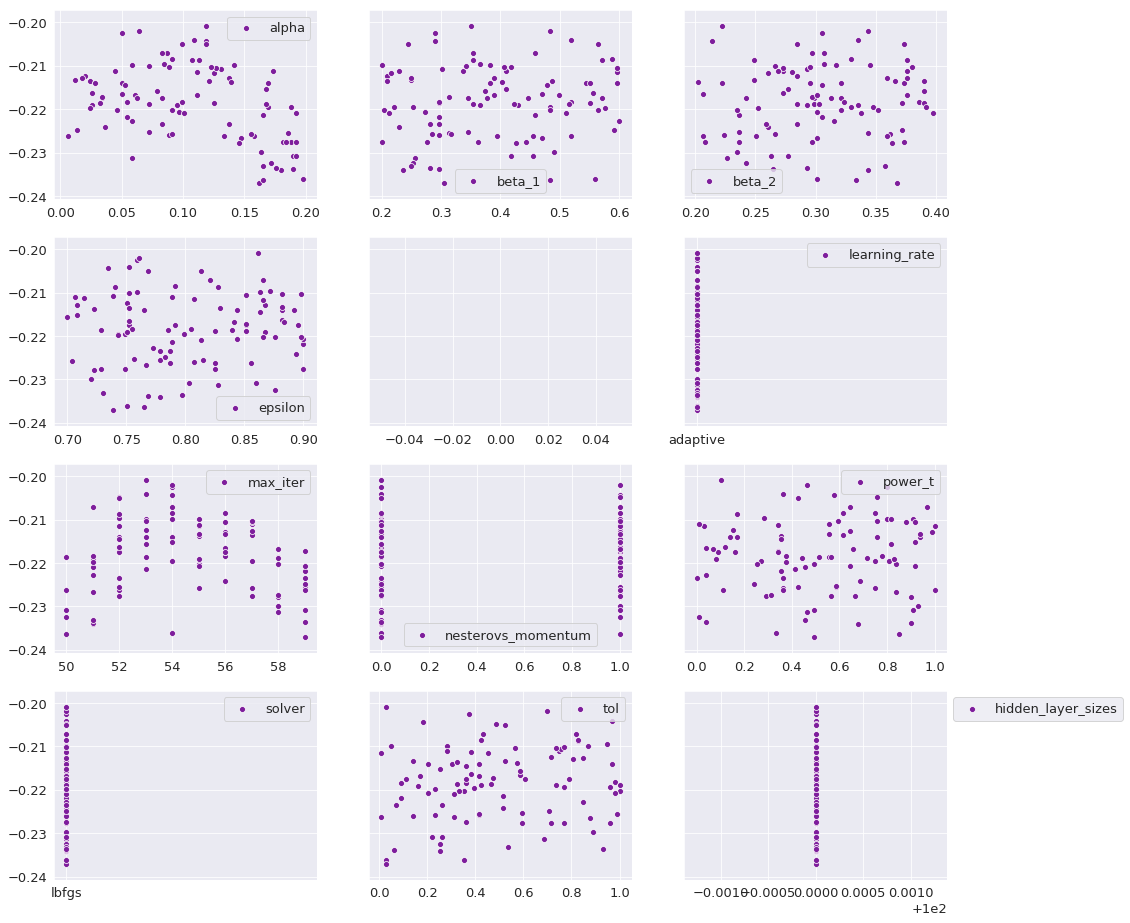

In [20]:
plot_params(MLP_params, MLP_results)

Finding Variables...

top score r_2: 0.5223225025616942
top score explained variance: 0.523698154464
best score rmse: 0.741768703314

control test - forcast using exact values of previous week:
top score r_2: 0.402915094814
top score explained variance: 0.402915094814
best score rmse: 0.554700196225

Top Scoring Variables:


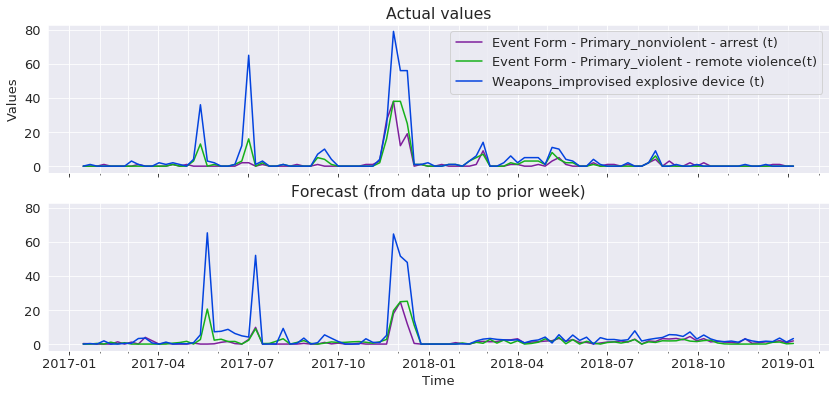

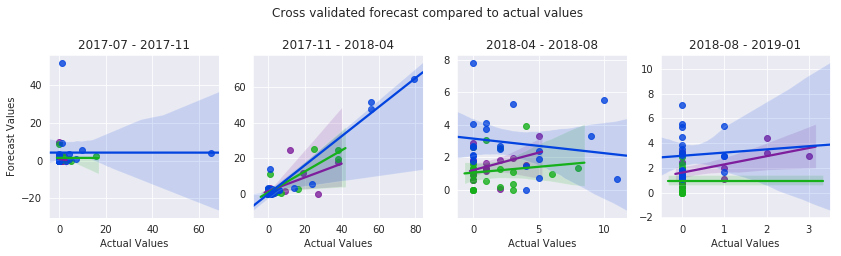

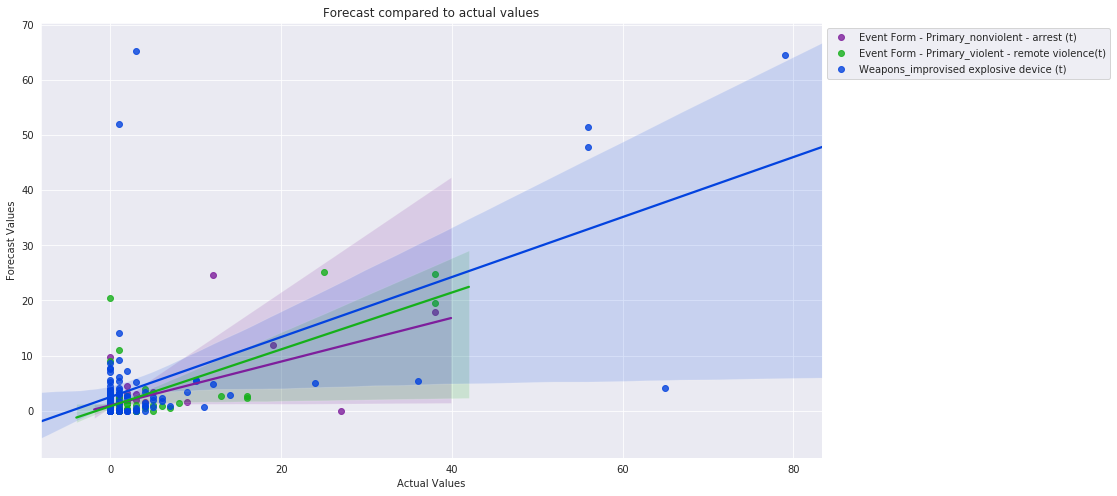

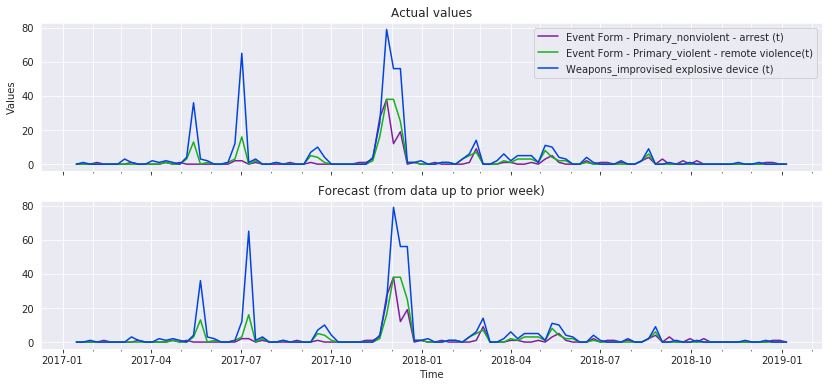

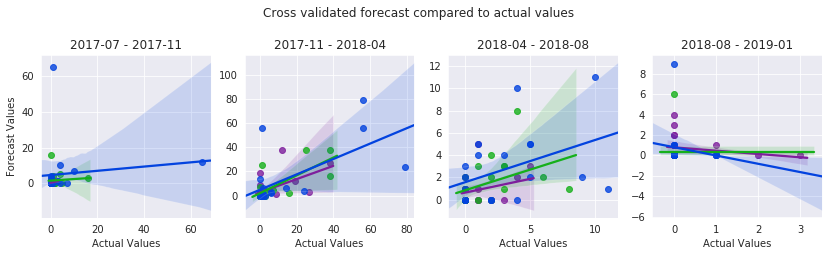

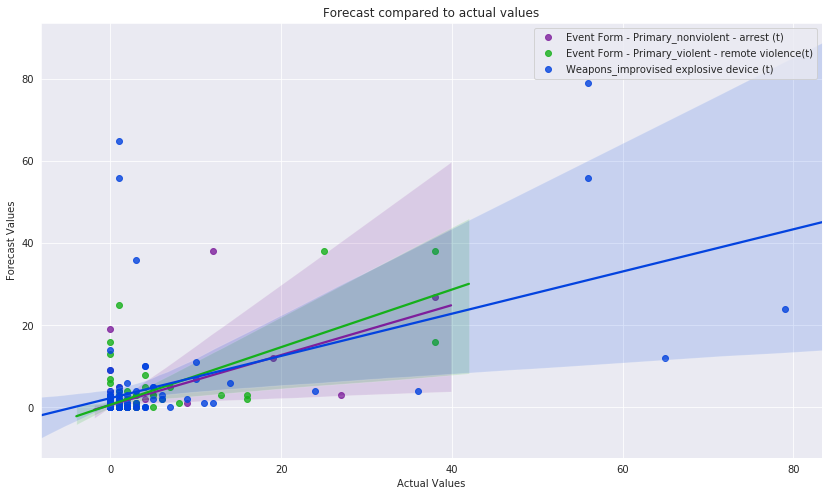

scores  \
                                                          r_2   
Event Form - Primary_violent - remote violence(t)    0.522323   
Event Form - Primary_nonviolent - arrest (t)         0.367007   
Weapons_improvised explosive device (t)               0.24779   
Actor 2 - Target_group of civilians (t)              0.130008   
Cause - Primary_political - other political iss... -0.0733557   
Event Form - Primary_violent - symbolic violenc...  -0.106488   
Female injured(t)                                   -0.191597   
Actor 2 - Target_family/relative(t)                 -0.262219   
Event Form - Primary_violent - vandalism(t)          -0.29738   
Actor 1 - Affiliation_political organization/po...  -0.346982   

                                                                       \
                                                   explained_variance   
Event Form - Primary_violent - remote violence(t)            0.523698   
Event Form - Primary_nonviolent - arrest (t)                 0.367294   
Weapons_improvised explosive device (t)                      0.248617   
Actor 2 - Target_group of civilians (t)                      0.132024   
Cause - Primary_political - other political iss...         -0.0616521   
Event Form - Primary_violent - symbolic violenc...          -0.104126   
Female injured(t)                                           -0.185618   
Actor 2 - Target_family/relative(t)                         -0.260987   
Event Form - Primary_violent - vandalism(t)                 -0.273056   
Actor 1 - Affiliation_political organization/po...          -0.328455   

                                                                            \
                                                   root_mean_squared_error   
Event Form - Primary_violent - remote violence(t)                  4.29673   
Event Form - Primary_nonviolent - arrest (t)                       4.00701   
Weapons_improvised explosive device (t)                            11.2407   
Actor 2 - Target_group of civilians (t)                            7.28249   
Cause - Primary_political - other political iss...                 4.67266   
Event Form - Primary_violent - symbolic violenc...                  7.9054   
Female injured(t)                                                  2.75486   
Actor 2 - Target_family/relative(t)                                3.18721   
Event Form - Primary_violent - vandalism(t)                        3.17059   
Actor 1 - Affiliation_political organization/po...                 8.98771   

                                                   control_scores  \
                                                              r_2   
Event Form - Primary_violent - remote violence(t)        0.402915   
Event Form - Primary_nonviolent - arrest (t)             0.216831   
Weapons_improvised explosive device (t)                 0.0283659   
Actor 2 - Target_group of civilians (t)                 -0.467861   
Cause - Primary_political - other political iss...      -0.469136   
Event Form - Primary_violent - symbolic violenc...      -0.438543   
Female injured(t)                                       -0.721079   
Actor 2 - Target_family/relative(t)                     -0.370386   
Event Form - Primary_violent - vandalism(t)             -0.543737   
Actor 1 - Affiliation_political organization/po...      -0.496253   

                                                                       \
                                                   explained_variance   
Event Form - Primary_violent - remote violence(t)            0.402915   
Event Form - Primary_nonviolent - arrest (t)                 0.216831   
Weapons_improvised explosive device (t)                     0.0283659   
Actor 2 - Target_group of civilians (t)                     -0.467861   
Cause - Primary_political - other political iss...          -0.469063   
Event Form - Primary_violent - symbolic violenc...          -0.438543   
Female injured(t)                              

In [21]:
model = MLPRegressor(random_state=56, **MLP_best_params)
    
print("Finding Variables...")
scores, top = find_var(X_week, y_week, model, n_true=20, verbose=2, s_plot=0, n_plot=3)

#extract and plot feature coefs - this is not currently working for Neural Nets
#coefs = get_coefs(X_train, y_train, model)
#coefframe = interpret_coefs(coefs,X_train,top.index)

    #print top 10 scores that beat control
top[:10]

Using the best tuned MLPRegressor does not result in many high scoring variables. However, an extremely interesting result is it seems to learn how to predict 3 of them very accurately in advance of a major spike. This could be a promising future application for machine learning with Nepal Monitor.

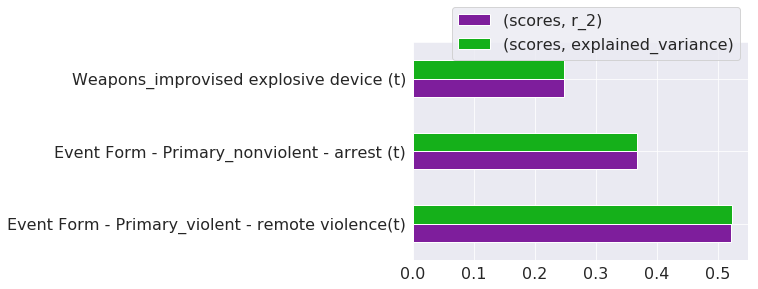

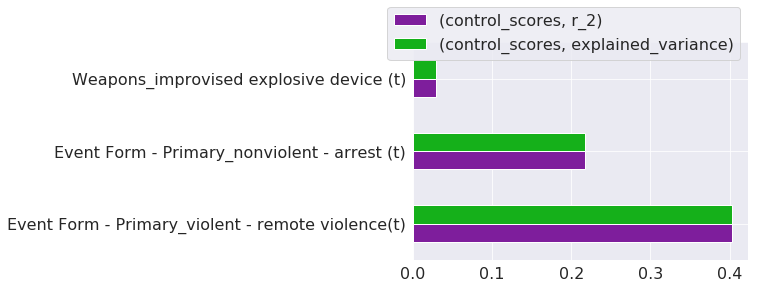

In [22]:
#Plot top 3 variables from MLPRegressor for presentation

plt.rcParams.update({'font.size': 16})
top.iloc[:3,:2].plot(kind='barh')
plt.legend(bbox_to_anchor=(1,1.2))
plt.show()

#top.iloc[:3,1].plot(kind='barh', color=catpal[2])
#plt.legend(bbox_to_anchor=(1,1.1))
#plt.show()

top.iloc[:3,3:5].plot(kind='barh')
plt.legend(bbox_to_anchor=(1,1.2))
plt.show()

#top.iloc[:3,5].plot(kind='barh', color=catpal[2])
#plt.legend(bbox_to_anchor=(1,1.1))
#plt.show()

In [23]:
from sklearn.linear_model import Lasso

model.get_params(deep=True)

{'activation': 'relu',
 'alpha': 0.11919192323232324,
 'batch_size': 'auto',
 'beta_1': 0.34949494949494953,
 'beta_2': 0.22222222222222224,
 'early_stopping': False,
 'epsilon': 0.86161616161616161,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_iter': 53,
 'momentum': 0.9,
 'nesterovs_momentum': False,
 'power_t': 0.10101000898989897,
 'random_state': 56,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.030303009696969696,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [24]:
#Tune Lasso
model = Lasso(random_state=56)

Lasso_params = {#'alpha': [1],
             #'copy_X': True,
             'fit_intercept': [False],
             #'max_iter': np.linspace(0,2000,100),
             'normalize': [True,False],
             'positive': [True],
             'precompute': [True,False],
             #'random_state': 56,
             'selection': ['random'],
             'tol': np.linspace(0.00000001,.2,100)}
 
Lasso_best_params, Lasso_best_score, Lasso_results = random_search(Lasso_params, model, 100)
print('\nbest parameters',Lasso_best_params)
print('best score',Lasso_best_score)
#Next try plotting parameters next to resulting scores

/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/nhorning/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective di


best parameters {'tol': 0.048484856060606062, 'selection': 'random', 'precompute': False, 'positive': True, 'normalize': True, 'fit_intercept': False}
best score -0.347413854958


plotting 6 params...


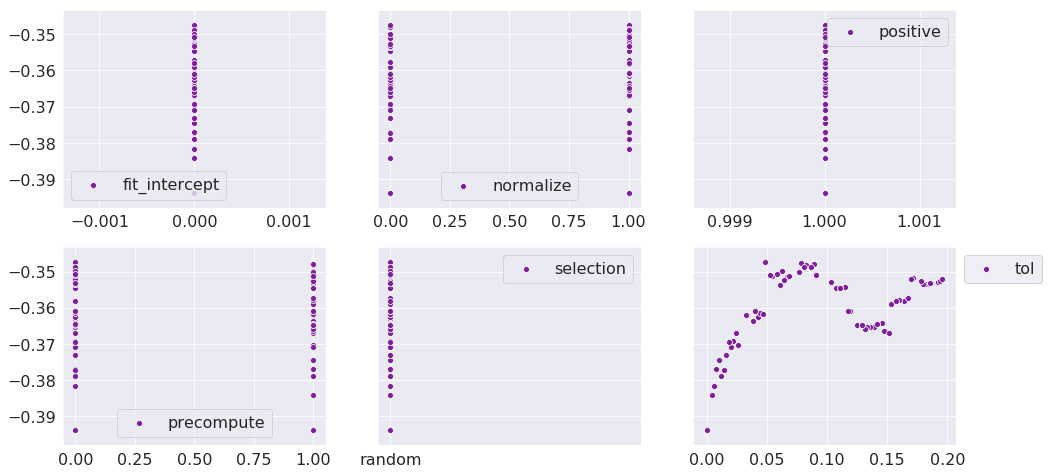

In [25]:
plot_params(Lasso_params, Lasso_results)

Lasso has so far been the 3rd best model in the comparative evaluation. Optimizing it with Random_Search found a few parameters that performed better than default. The remaining variation in scores appears to be mostly a function of tolerance.

Finding Variables...

Top Scoring Variables:


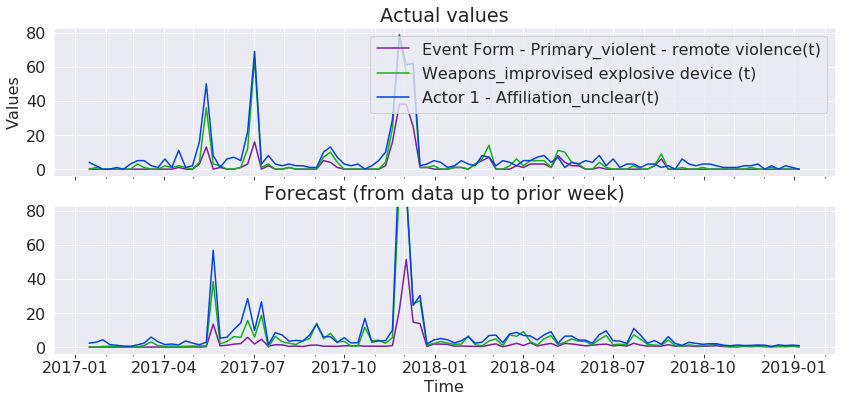

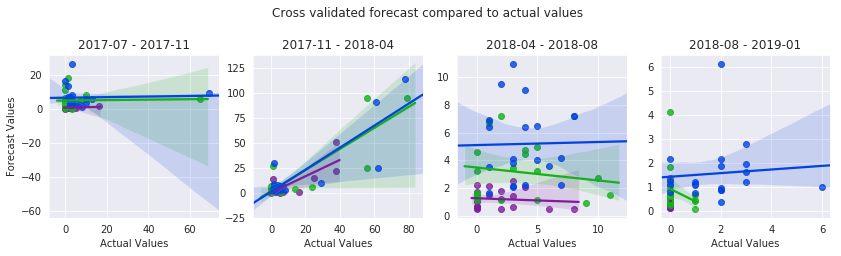

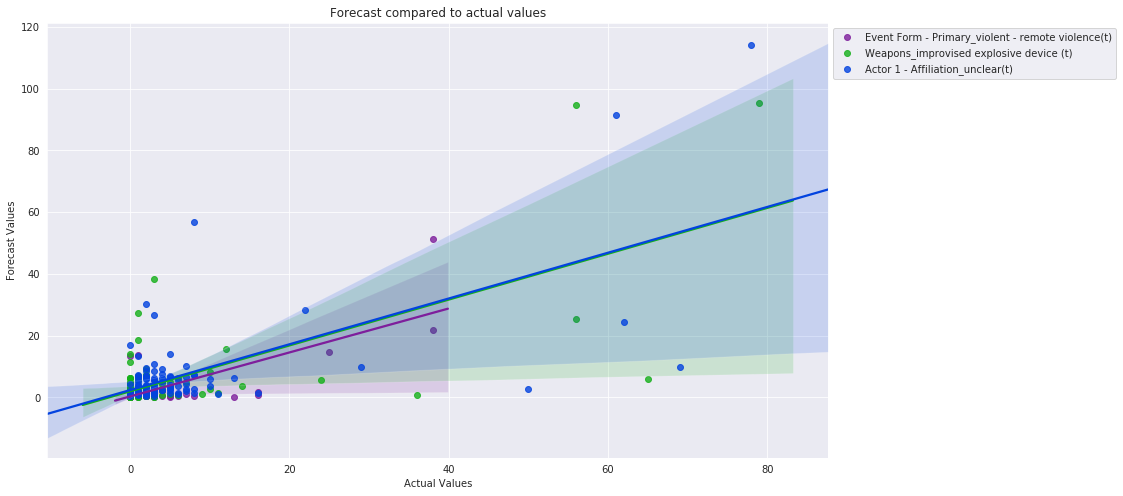

scores  \
                                                          r_2   
Event Form - Primary_violent - remote violence(t)    0.557662   
Weapons_improvised explosive device (t)              0.351826   
Actor 1 - Affiliation_unclear(t)                     0.215642   
Actor 1 - Youth/non-youth_na(t)                      0.146065   
Actor 2 - Target_group of civilians (t)              0.119002   
Event Form - Primary_violent - symbolic violenc...  0.0598545   
Event Form - Secondary_violent - vandalism(t)       -0.034231   
Cause - Primary_political - other political iss... -0.0408676   
Event Form - Primary_violent - unclear(t)          -0.0466091   
Event Form - Primary_nonviolent - threat/intimi... -0.0527029   

                                                                       \
                                                   explained_variance   
Event Form - Primary_violent - remote violence(t)            0.560222   
Weapons_improvised explosive device (t)                      0.355391   
Actor 1 - Affiliation_unclear(t)                             0.217547   
Actor 1 - Youth/non-youth_na(t)                              0.160427   
Actor 2 - Target_group of civilians (t)                      0.125668   
Event Form - Primary_violent - symbolic violenc...          0.0642726   
Event Form - Secondary_violent - vandalism(t)             -0.00588261   
Cause - Primary_political - other political iss...         -0.0390482   
Event Form - Primary_violent - unclear(t)                  -0.0021183   
Event Form - Primary_nonviolent - threat/intimi...         -0.0507939   

                                                                            \
                                                   root_mean_squared_error   
Event Form - Primary_violent - remote violence(t)                  4.13474   
Weapons_improvised explosive device (t)                            10.4345   
Actor 1 - Affiliation_unclear(t)                                   12.0962   
Actor 1 - Youth/non-youth_na(t)                                    4.39382   
Actor 2 - Target_group of civilians (t)                            7.32841   
Event Form - Primary_violent - symbolic violenc...                 7.28698   
Event Form - Secondary_violent - vandalism(t)                       0.6884   
Cause - Primary_political - other political iss...                 4.60141   
Event Form - Primary_violent - unclear(t)                         0.561653   
Event Form - Primary_nonviolent - threat/intimi...                 1.03263   

                                                   control_scores  \
                                                              r_2   
Event Form - Primary_violent - remote violence(t)        0.402915   
Weapons_improvised explosive device (t)                 0.0283659   
Actor 1 - Affiliation_unclear(t)                        0.0916371   
Actor 1 - Youth/non-youth_na(t)                         0.0124281   
Actor 2 - Target_group of civilians (t)                 -0.467861   
Event Form - Primary_violent - symbolic violenc...      -0.438543   
Event Form - Secondary_violent - vandalism(t)            -0.88862   
Cause - Primary_political - other political iss...      -0.469136   
Event Form - Primary_violent - unclear(t)               -0.722699   
Event Form - Primary_nonviolent - threat/intimi...       -0.54728   

                                                                       \
                                                   explained_variance   
Event Form - Primary_violent - remote violence(t)            0.402915   
Weapons_improvised explosive device (t)                     0.0283659   
Actor 1 - Affiliation_unclear(t)                            0.0916376   
Actor 1 - Youth/non-youth_na(t)                             0.0124281   
Actor 2 - Target_group of civilians (t)                     -0.467861   
Event Form - Primary_violent - symbolic violenc...          -0.438543   
Event Form - Secondary_violent - vandalism(t)  

In [26]:
model = Lasso(random_state=56, **Lasso_best_params)
    
print("Finding Variables...")
scores, top = find_var(X_week, y_week, model, n_true=20, verbose=1, s_plot=0, n_plot=3)

#extract and plot feature coefs - this is not currently working for Neural Nets
#coefs = get_coefs(X_train, y_train, model)
#coefframe = interpret_coefs(coefs,X_train,top.index)

    #print top 10 scores that beat control
top[:10]

### Comparatively Evaluate Predictive Models
The function below was used to iteratively compare and select the best models. Models were commented out as they were eliminated for various reasons.

In [52]:
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import TheilSenRegressor



def search_models(modellist, catlist, verbose=False, random_state=False):
    '''function to comparatively evaluate a list of models'''
    #create a dataframe for the scores
    scoresdf = pd.DataFrame(index=catlist)
    
    #turn warnings off to avoid clutter
    warnings.filterwarnings("ignore")
    
    #loop through the models and evaluate them
    for model in modellist:
        
        #get the name of the model
        modelstring = str(model).split('(')[0]
        
        #print the name of the model
        print('\n{}:'.format(modelstring))
        
        #prune X variables according to top coefs?
        topcoefs = coefframe.loc[coefframe.iloc[:,0] > 0.01]
        
        #evaluate model
        print('Evaluating model...')
        _, model_scoresdf = find_var(X_week, y_week, model, n_true=20, verbose=verbose, random_state=random_state)
        
        #print the top 3 scores in explained variance
        print('Top 3 scores:\n',model_scoresdf[('scores','explained_variance')].sort_values(ascending=False)[:3])
        
        #if we haven't added anything to scores df yet, grab the control scores and add them
        if scoresdf.shape[1] < 3:
            scoresdf = pd.concat([scoresdf, model_scoresdf.iloc[:,3:6]], axis=1)
        
        #add the scores from the model to the dataframe
        scoresdf = pd.concat([scoresdf, model_scoresdf.iloc[:,:3]], axis=1)
        
        #label first section of df < debug later
        new_cols = scoresdf.columns.tolist()
        for x in range(3):
            i = len(new_cols)- 1 - x
            new_cols[i] = (modelstring, new_cols[i][1])
            #print('appended!', modelstring, 'to', new_cols[x][0])
        scoresdf.columns = new_cols
        print('appended', modelstring, 'to columns')
                
    print('Bing!')
    return scoresdf

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)
    random_state=56
    modellist=[#LinearRegression(),
               RandomForestRegressor(random_state=random_state,**best_params),
               MLPRegressor(random_state=random_state,**MLP_best_params),
               #BayesianRidge(),
               #ARDRegression(),# <throws a big error
               
               ElasticNet(random_state=random_state),
               #ElasticNetCV(random_state=random_state), < save automatic Cv for holdout sets
               #HuberRegressor(),
               #Lars(random_state=random_state), < tiny results
               Lasso(random_state=random_state, **Lasso_best_params)] #add after fixing function
               #MultiTaskLassoCV(random_state=random_state),<way too slow
               #PassiveAggressiveRegressor(random_state=random_state),
               #Perceptron(random_state=random_state),
               #TheilSenRegressor(random_state=random_state)]
               #RidgeCV()]
    
    scoresdf = search_models(modellist, y_week.columns, random_state=random_state)
    scoresdf.head()


RandomForestRegressor:
Evaluating model...
Top 3 scores:
 Actor 1 - Youth/non-youth_unknown(t)        0.331969
Collective / Interpersonal_collective(t)    0.324302
Violent / Nonviolent_nonviolent(t)          0.316213
Name: (scores, explained_variance), dtype: object
appended RandomForestRegressor to columns

MLPRegressor:
Evaluating model...
Top 3 scores:
 Event Form - Primary_violent - remote violence(t)    0.523698
Event Form - Primary_nonviolent - arrest (t)         0.367294
Weapons_improvised explosive device (t)              0.248617
Name: (scores, explained_variance), dtype: object
appended MLPRegressor to columns

ElasticNet:
Evaluating model...
Top 3 scores:
 Event Form - Secondary_violent - abduction(t)   -0.0247825
Event Form - Secondary_violent - vandalism(t)   -0.0413763
Event Form - Primary_violent - unclear(t)       -0.0564963
Name: (scores, explained_variance), dtype: object
appended ElasticNet to columns

Lasso:
Evaluating model...
Top 3 scores:
 Event Form - Primary_v

In [53]:
scoresdf

,"(control_scores, r_2)","(control_scores, explained_variance)","(control_scores, root_mean_squared_error)","(RandomForestRegressor, r_2)","(RandomForestRegressor, explained_variance)","(RandomForestRegressor, root_mean_squared_error)","(MLPRegressor, r_2)","(MLPRegressor, explained_variance)","(MLPRegressor, root_mean_squared_error)","(ElasticNet, r_2)","(ElasticNet, explained_variance)","(ElasticNet, root_mean_squared_error)","(Lasso, r_2)","(Lasso, explained_variance)","(Lasso, root_mean_squared_error)"
Actor 1 - Affiliation_citizen/individuals(t),-0.117853,-0.117293,9.02081,0.11501,0.115074,8.02643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil society/cso/ngo - cso/ngo(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil society/cso/ngo - hrd(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil society/cso/ngo - women's rights activists(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil state institutions - government and civil servants at central level(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil state institutions - local authorities (t),-0.283304,-0.283254,1.53485,-0.0542441,-0.051284,1.39114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil state institutions - other state institutions(t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil state institutions - state-level authorities for (t),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_criminal(t),-1.10282,-1.10233,1.25576,-0.0371997,-0.0054371,0.881932,NaN,NaN,NaN,-0.900682,-0.776354,1.19387,-0.635943,-0.57475,1.10761
Actor 1 - Affiliation_education sector/teachers (t),-0.9098,-0.90961,1.92654,-0.0287686,-0.0246464,1.41398,NaN,NaN,NaN,-0.767689,-0.693121,1.85347,-0.270378,-0.223759,1.57127


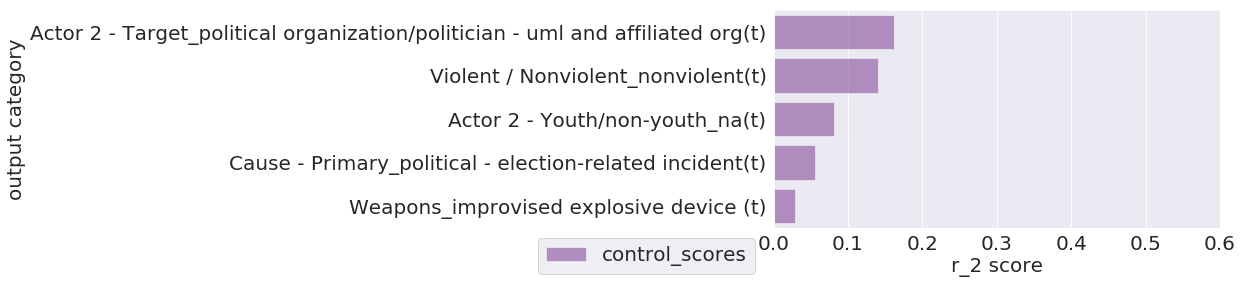

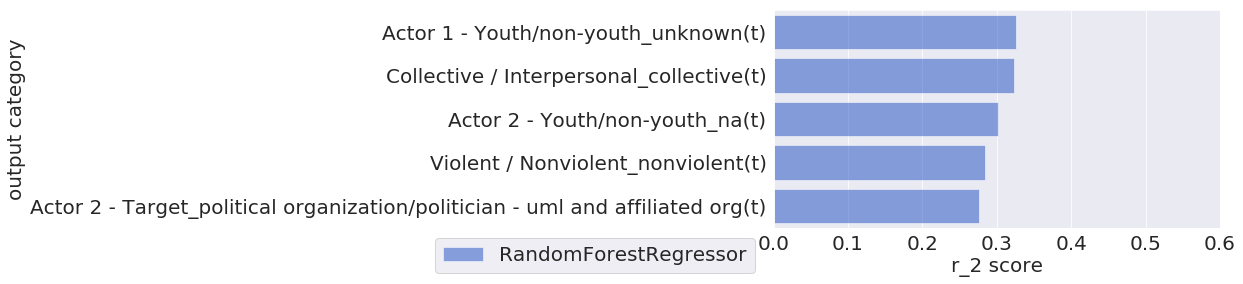

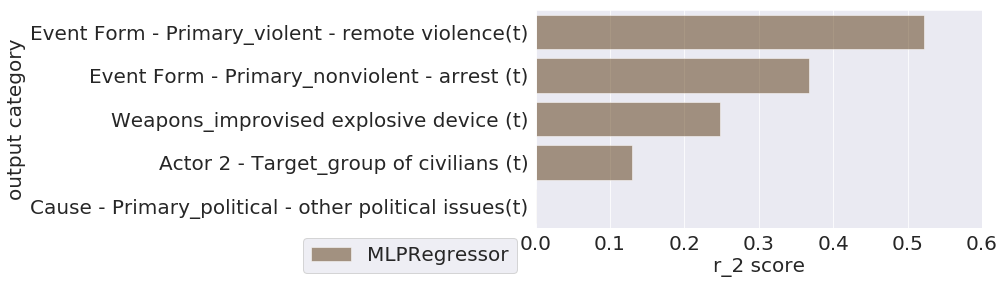

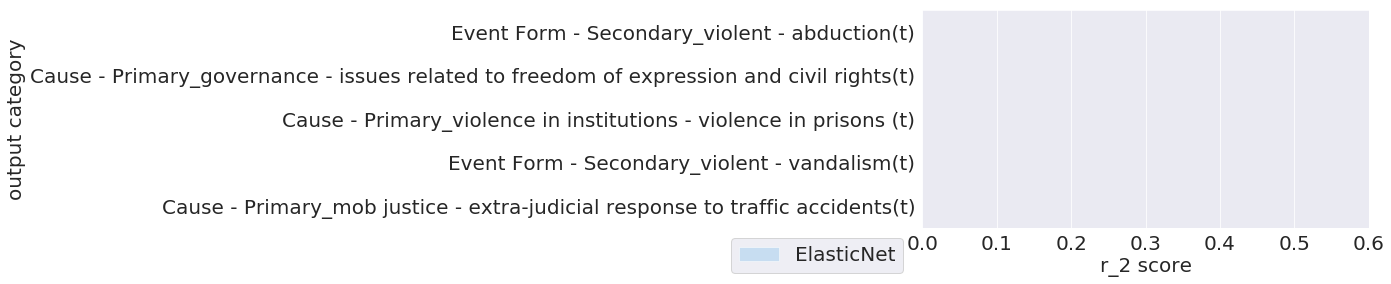

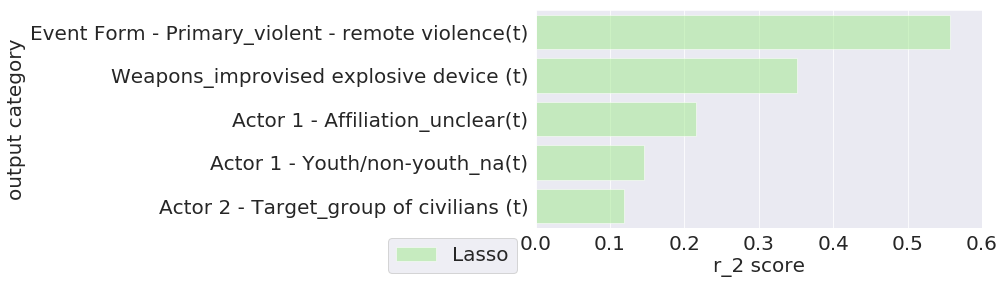

,"(control_scores, r_2)","(RandomForestRegressor, r_2)","(MLPRegressor, r_2)","(ElasticNet, r_2)","(Lasso, r_2)"
Actor 1 - Affiliation_citizen/individuals(t),-0.117853,0.11501,NaN,NaN,NaN
Actor 1 - Affiliation_civil society/cso/ngo - cso/ngo(t),NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil society/cso/ngo - hrd(t),NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil society/cso/ngo - women's rights activists(t),NaN,NaN,NaN,NaN,NaN
Actor 1 - Affiliation_civil state institutions - government and civil servants at central level(t),NaN,NaN,NaN,NaN,NaN


In [54]:

#Plot the best scores of various regressors - change to top 5? seperately?
colr=0
expv = scoresdf.iloc[:,0::3]#.dropna()
for col in expv.columns:
    data = expv.sort_values(col, ascending=False)[:5]
    f, ax = plt.subplots(1,1, figsize=(8,4))
    ax.set_xlim(-.0,.6)

    #plot = expv.loc[expv[col] > 0]
    #if len(expv) > 0:
    sns.barplot(x=col, y=data.index, data=data, color=catpal[colr*2], label=col[0], alpha=0.5, ax=ax, dodge=False)
    colr+=1
    #sns.barplot(y=expv.index, data=expv, alpha=0.5, ax=ax)    
    plt.xlabel(expv.columns[0][1]+' score')
    plt.ylabel('output category')
    plt.legend(bbox_to_anchor=(-0.02,0))
    plt.rcParams.update({'font.size': 20})
    plt.show()
        
#for col in scoresdf.columns[2::3]:
    #plot = scoresdf[[col]].sort_values(col).loc[scoresdf[col] < .3]
    #if len(plot) > 0:
        #sns.barplot(x=col, y=plot.index, data=plot)
        #plt.show()
expv.head()

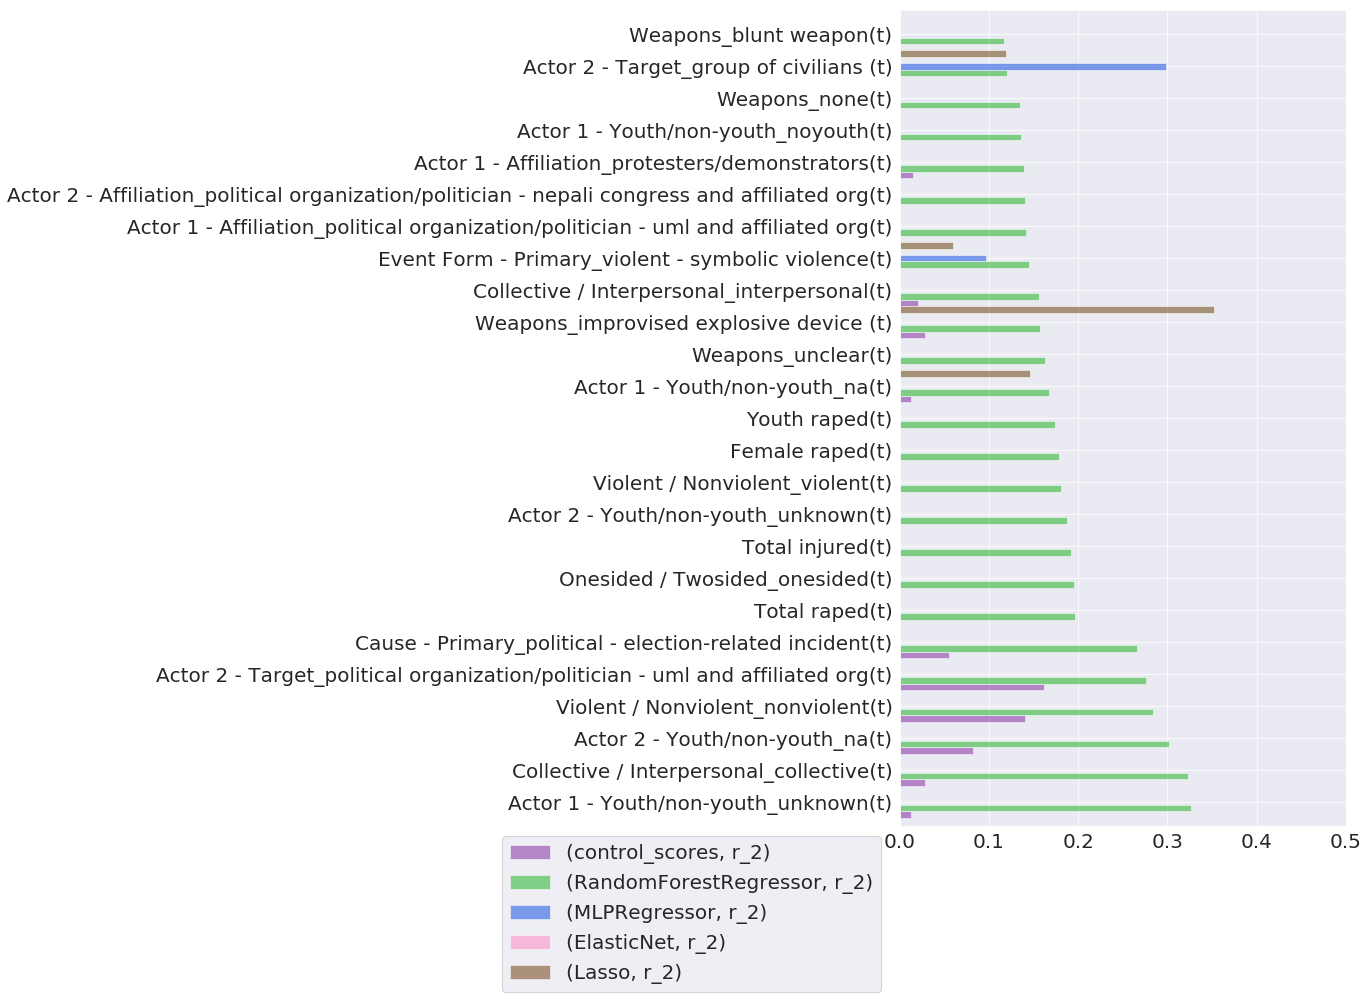

In [47]:
#plot them all together - some variables missing

#plt.figure(figsize=(8,12))
expv.plot(kind='barh', figsize=(8,15), width=1, alpha=.5)
plt.legend(bbox_to_anchor=(-0.02,0))
plt.xlim(-.0,.5)
plt.show()

In [ ]:
#an attempt to optmize by lookback range has been removed